In [1]:
%config Completer.use_jedi = False
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
# Set the display option to show all columns
pd.set_option('display.max_columns', None)  # No column limit
# pd.set_option('display.max_rows', None)     # No row limit

from pandas.api.types import CategoricalDtype
import math
import matplotlib as mpl
#mpl.use('pdf')
import matplotlib.pyplot as plt
import matplotlib.font_manager
import numpy as np
from collections import OrderedDict, Counter
import matplotlib
import seaborn as sns
from pylab import cm
from matplotlib.cbook import boxplot_stats
from matplotlib.legend_handler import HandlerTuple
from matplotlib.patches import Patch
from matplotlib.colors import Normalize, to_rgba

from scipy.stats.mstats import hmean

from pprint import pprint
from IPython.display import display, HTML

import os
import subprocess
# import pickle
import dill as pickle  # Use dill instead of pickle
import warnings 
warnings.filterwarnings('ignore', category=FutureWarning)

# import fitz  # PyMuPDF
from reportlab.lib.pagesizes import landscape, letter
from reportlab.pdfgen import canvas
from reportlab.lib.utils import ImageReader
import io  # Import io for byte data handling
from PIL import Image

# Load any global variables (and functions) from pickle object (defined in benchmark_aggregation)
(need to move color palette here, as well as dictionary device->color)

In [2]:
# Load the objects from the file
with open('objects.pkl', 'rb') as f:
    objects_to_load = pickle.load(f)

ranges_dev = objects_to_load['ranges_dev']
ranges_dev_backup = objects_to_load['ranges_dev_backup']
y_limit_dictionary = objects_to_load['y_limit_dictionary']
llc_thresholds = objects_to_load['llc_thresholds']
ranges_impl_arch = objects_to_load['ranges_impl_arch']
ranges_impl_arch_backup = objects_to_load['ranges_impl_arch_backup']
ranges_memr = objects_to_load['ranges_memr']
ranges_anr = objects_to_load['ranges_anr']
ranges_skew = objects_to_load['ranges_skew']
ranges_ann = objects_to_load['ranges_ann']
ranges_crs = objects_to_load['ranges_crs']
ranges_size = objects_to_load['ranges_size']
ranges_regularity = objects_to_load['ranges_regularity']
cat_list = objects_to_load['cat_list']
ranges_list = objects_to_load['ranges_list']

# functions
set_category = objects_to_load['set_category']
set_category2 = objects_to_load['set_category2']
filter_ranges_impl_arch = objects_to_load['filter_ranges_impl_arch']
calculate_format_wins = objects_to_load['calculate_format_wins']

---
# Load benchmark dataframes

In [3]:
%%time
groupreps = pd.read_csv('synthetic_benchmarks_all-devices_all.csv')
# groupreps = pd.read_csv('validation_real_benchmarks_all-devices_all2.csv')
print('groupreps:', groupreps.shape)

group_system_best = pd.read_csv('synthetic_benchmarks_all-devices_best-of.csv')
# group_system_best = pd.read_csv('validation_real_all-devices_best-of2.csv')
print('group_system_best:', group_system_best.shape)

def remove_formats(df, formats_to_discard):
    for ftd in formats_to_discard:
        df = df[df['format_name'] != ftd]
    return df

# formats_to_discard = ['Vec-CSR']
formats_to_discard = []

groupreps = remove_formats(groupreps, formats_to_discard)
group_system_best = remove_formats(group_system_best, formats_to_discard)

def remove_devices(df, devices_to_discard):
    for dtd in devices_to_discard:
        df = df[df['System'] != dtd]
    return df

devices_to_discard = []

groupreps = remove_devices(groupreps, devices_to_discard)
group_system_best = remove_devices(group_system_best, devices_to_discard)

print('\nAfter discarding specific devices')
print('groupreps:', groupreps.shape)
print('group_system_best:', group_system_best.shape)

groupreps: (1252763, 38)
group_system_best: (190519, 38)

After discarding specific devices
groupreps: (1252763, 38)
group_system_best: (190519, 38)
CPU times: user 3.88 s, sys: 1.35 s, total: 5.24 s
Wall time: 5.26 s


---

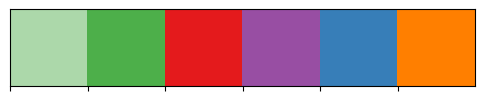

In [4]:
# palette = [
#     '#FF6F61','#FFD166','#5E819D','#8F3985','#A2A18F',
#     '#3C6E71','#D5AB9C',
#     '#7D9EA8', '#D9BF77', '#A8D0DB',
#     '#EAD3C6', '#7A9D7E', '#355C7D',
#     '#FFE156', '#ACD8AA',
#     '#63774D','#6B4226','#F0B8A6','#6C5B7B',
# ]
palette = ['#ACD8AA','#4daf4a','#e41a1c','#984ea3','#377eb8','#ff7f00']

sns.palplot(palette)
plt.show()

In [5]:
def change_colors(ranges_dev, color_dictionary):
    color_dictionary_custom = {k: v for k, v in color_dictionary.items() if k in ranges_dev}
    # print(color_dictionary_custom)
    sns.set_palette(color_dictionary_custom.values())
    sns.color_palette()

# all devices that will be used
# ranges_dev = [
#                 'NVIDIA-P100', 'NVIDIA-V100', 'NVIDIA-A100', 'NVIDIA-H100', 'AMD-MI250',
#                 'AMD-EPYC-24', 'AMD-EPYC-64', 
#                 'INTEL-XEON-14', 'INTEL-ICY-16', 'INTEL-SAPPHIRE-56',
#                 'ARM-NEON-80', 'ARM-GRACE-72',
#                 'IBM-POWER9-32'
#              ]

ranges_dev = ['NVIDIA-A100', 'NVIDIA-H100', 'AMD-MI250', 'AMD-EPYC-64', 'INTEL-SAPPHIRE-56', 'ARM-GRACE-72']
palette = ['#acd8aa', '#4daf4a','#e41a1c','#984ea3','#377eb8','#ff7f00']

color_dictionary = dict(zip(ranges_dev, palette[:len(ranges_dev)]))

sns.set_palette(color_dictionary.values())
sns.color_palette()


[(0.6745098039215687, 0.8470588235294118, 0.6666666666666666),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (1.0, 0.4980392156862745, 0.0)]

In [6]:
# original for IEEE paper
width = 3.487
height = width/1.618

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({'font.size': 7})

In [7]:
# 'dodge' argument explained here -> https://stackoverflow.com/questions/49078697/seaborn-boxplots-shifted-incorrectly-along-x-axis 
def harry_plotter(type, plot_df, plot_x_axis_list, plot_y_axis_list, select_str, plot_id, 
                  ranges_impl_arch, 
                  boxplot_width = 0.8, rotation = 30, adj_left = .1, adj_bottom = .2, adj_right = .99, adj_top = .88, 
                  no_sort=False, hue_hue = 'None', hue_hue_order = [], dodge=True, no_legend=False, no_title=True,
                  show_size=False, systemaki='',
                  no_x_axis=False, no_x_axis_title=False, no_y_axis_title=False, add_separators = False,
                  secondary_axis=False, plot_secondary_y_itter = '', secondary_data = [], secondary_annot = [], no_y2_axis=False,
                  showfliers=True, fliers_format='cu-CSR'
                 ):
    for plot_x_itter in plot_x_axis_list:
        if no_sort:
            plot_df_sorted = plot_df
        else:
            dataTypeX = plot_df[plot_x_itter].dtype
            if dataTypeX == np.float64 or dataTypeX == np.int64 or dataTypeX == float or dataTypeX == int:
                plot_df_sorted = plot_df.sort_values(plot_x_itter)
            else:
                plot_df_sorted = plot_df
                if plot_x_itter == 'mem_range':
                    cat_it = CategoricalDtype(ranges_memr, ordered=True)
                if plot_x_itter == 'regularity':
                    cat_it = CategoricalDtype(ranges_regularity, ordered=True)
                if plot_x_itter == 'impl_arch':
                    cat_it = CategoricalDtype(ranges_impl_arch, ordered=True)
                if plot_x_itter == 'System':
                    cat_it = CategoricalDtype(ranges_dev, ordered=True)
                if plot_x_itter == 'anr_categ':
                    cat_it = CategoricalDtype(ranges_anr, ordered=True)
                if plot_x_itter == 'skew_categ':
                    cat_it = CategoricalDtype(ranges_skew, ordered=True)

                plot_df_sorted[plot_x_itter] = plot_df_sorted[plot_x_itter].astype(cat_it)
                plot_df_sorted = plot_df_sorted.sort_values(plot_x_itter)

        for plot_y_itter in plot_y_axis_list:
            fig, axs = plt.subplots()
            if hue_hue == 'None':
                if(type == 'violin'):
                    sns_plot = sns.violiplot(linewidth=0.6, width=boxplot_width, data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, ax=axs, dodge=dodge)
                if(type == 'scatter'):
                    sns_plot = sns.scatterplot(data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, ax=axs)
                if(type == 'box'):
                    sns_plot = sns.boxplot(fliersize = 0.3, linewidth=boxplot_width, width=boxplot_width, data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, ax=axs, dodge=dodge)
            else:
                if(hue_hue_order != []):
                    if(type == 'violin'):
                        sns_plot = sns.violinplot(linewidth=0.3, width=boxplot_width, data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, hue=hue_hue, hue_order=hue_hue_order, ax=axs, dodge=dodge, inner="quart")
                    if(type == 'scatter'):
                        # sns_plot = sns.scatterplot(data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, hue=hue_hue, hue_order=hue_hue_order, ax=axs)
                        sns_plot = sns.stripplot(data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, hue=hue_hue, hue_order=hue_hue_order, ax=axs, jitter=0.25, s=2, alpha=1)
                    if(type == 'box'):
                        sns_plot = sns.boxplot(fliersize = 0.3, linewidth=boxplot_width, width=boxplot_width, data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, hue=hue_hue, hue_order=hue_hue_order, ax=axs, dodge=dodge, showfliers=showfliers)
                else:
                    if(type == 'violin'):
                        sns_plot = sns.violinplot(linewidth=0.6, width=boxplot_width, data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, hue=hue_hue, ax=axs, dodge=dodge, inner="quart")
                    if(type == 'scatter'):
                        # sns_plot = sns.scatterplot(data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, hue=hue_hue, ax=axs)
                        sns_plot = sns.stripplot(data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, hue=hue_hue, ax=axs, jitter=0.25, s=2, alpha=1)
                    if(type == 'box'):
                        sns_plot = sns.boxplot(fliersize = 0.3, linewidth=boxplot_width, width=boxplot_width, data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, hue=hue_hue, ax=axs, dodge=dodge, showfliers=showfliers)
            axs.set_xticks(axs.get_xticks())
            if(hue_hue_order != []):               
                # reordering the labels
                handles, labels = axs.get_legend_handles_labels()
                if(handles != []):
                    order = [labels.index(i) for i in hue_hue_order]
                    plt.legend([handles[i] for i in order], [labels[i] for i in order], 
                               title = hue_hue.replace('_categ',''), fancybox=True, frameon=False)

            # if(no_legend==True):
            #     axs.get_legend().remove()
            # else:
            if(no_legend!=True):
                #remove title from Legend
                handles, labels = axs.get_legend_handles_labels()
                axs.legend(handles=handles[0:], labels=labels[0:])
                # axs.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=len(ranges_dev), frameon=False)
                axs.legend(loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=len(ranges_dev), frameon=False)

            if(plot_x_itter == 'impl_arch'):
                if(add_separators  == True):
                    add_where = []
                    xtick_items = axs.get_xticklabels()
                    prev_platf = xtick_items[0].get_text().split('\t')[0] # initialize previous platform
                    for item in xtick_items:
                        platf = item.get_text().split('\t')[0]
                        if(platf!=prev_platf):
                            # when changing which platform is shown, add a separator right before to make it distinct from previous
                            add_where.append(item.get_position()[0]-0.5)
                        prev_platf = platf
                            
                    for pos in add_where:
                        plt.axvline(x=pos, color='gray', linewidth=0.15)
                
                # remove 'arch' from 'impl_arch'
                labels = [item.get_text().split('\t')[1] for item in axs.get_xticklabels()]
                axs.set_xticklabels(labels)
                axs.set_xlabel('Format name')

            if(plot_y_itter == 'energy_efficiency'):
                axs.set_ylabel('GFLOPs/W')
                # I set this limit as some outliers ( from Vectorized CSR ) caused it to reach 2.5
                # and compared to other devices, offered nothing more
                axs.set_ylim(bottom = 0, top=1.4)
            if(plot_y_itter == 'GFLOPs^2-per-W'):
                axs.set_ylabel('GFLOPs^2/W')
            if(plot_y_itter == 'gflops'):
                axs.set_ylabel('GFLOPs')
                if(showfliers==False):
                    # IQR method to filter out outliers
                    df = plot_df_sorted[plot_df_sorted['format_name']==fliers_format]
                    Q1 = df[plot_y_itter].quantile(0.25)
                    Q3 = df[plot_y_itter].quantile(0.75)
                    IQR = Q3 - Q1
                    lower_bound = Q1 - 1.5 * IQR
                    upper_bound = Q3 + 1.5 * IQR
                    plot_df_sorted_no_outliers = plot_df_sorted[(plot_df_sorted[plot_y_itter] >= lower_bound) & (plot_df_sorted[plot_y_itter] <= upper_bound)]
                    axs.set_ylim(bottom = 0, top=plot_df_sorted_no_outliers[plot_y_itter].max()*1.1)
                else:
                    axs.set_ylim(bottom = 0, top=plot_df_sorted[plot_y_itter].max()*1.1)

            if(plot_x_itter == 'anr_categ'):
                axs.set_xlabel('avg_nnz_per_row')
            if(plot_x_itter == 'skew_categ'):
                axs.set_xlabel('skew_coefficient')
            if(plot_x_itter == 'regularity'):
                axs.set_xlabel('regularity ( cross_row_similarity / avg_num_neighbours )')

            if(no_title==False):
                # axs.set_title('Select: %s' %(select_str))
                axs.set_title('%s' %(select_str))

            if(show_size==True):
                if(plot_x_itter=='System' or plot_x_itter=='mem_range' or plot_x_itter=='regularity' or plot_x_itter=='anr_categ' or plot_x_itter=='skew_categ'):
                    labels_new = [item.get_text() + '\n('+ str(plot_df_sorted[plot_df_sorted[plot_x_itter]==item.get_text()].shape[0])  +')' for item in axs.get_xticklabels()]
                else:
                    labels_new = [item.get_text() + '\n('+ str(plot_df_sorted[plot_df_sorted[plot_x_itter]==float(item.get_text())].shape[0])  +')' for item in axs.get_xticklabels()]
                axs.set_xticklabels(labels_new, fontsize = font)
                plt.xticks(rotation=45)#rotation)

            if(no_x_axis_title==True):
                axs.set_xlabel('')
            if(no_y_axis_title==True):
                axs.set_ylabel('')
            if(no_x_axis==True):
                axs.set_xticklabels([])
                axs.set_xlabel('')
                axs.set_xticks([], minor=False)#, major=False)
                
            if(secondary_axis==True):
                axs2 = axs.twinx()
                axs2.set_xlim(axs.get_xlim())
                axs2.bar(range(0, len(secondary_data)), height=secondary_data,align='center', width = 0.6, alpha = 0.1, color='g')

                if(plot_secondary_y_itter == 'mem_bw'):
                    axs2.set_ylabel('Memory Bandwidth (GB/s)')
                if(plot_secondary_y_itter == 'wins'):
                    if(no_y2_axis==True):
                        axs2.set_ylabel('')
                        # axs2.set_yticklabels([])
                        # axs2.set_yticks([], minor=False)#, major=False)
                    else:
                         axs2.set_ylabel('Wins percentage (%)')
                
                if(secondary_annot != []):
                    items = axs.get_xticklabels()
                    labels = [items[i].get_text() + '\n' + '(' + str(secondary_annot[i]) + '% peak performance)'  for i in range(len(items))]
                    axs.set_xticklabels(labels)

            if(systemaki != ''):
                axs.text( 0.02, 0.9, systemaki, fontsize=font, transform = axs.transAxes, )

            fig.subplots_adjust(left=adj_left, bottom=adj_bottom, right=adj_right, top=adj_top)

            plt.xticks(rotation=rotation)
            plt.setp( axs.xaxis.get_majorticklabels(), rotation=rotation )
            plt.tight_layout()

            select_str_id = select_str.replace('=', 'eq').replace('<', 'l').replace('>', 'g').replace(', ', '_').replace(',', '_').replace('\n', '_').replace(' ', '-')            
            if('-performance_' in select_str_id):
                select_str_id = select_str_id.split('-performance_')[0]
            else:
                select_str_id = select_str_id.split('__')[0]

            fig_name = './Plots/%s_Select-%s_x-%s_y-%s.pdf' % (plot_id, select_str_id, plot_x_itter, plot_y_itter)
            fig.savefig(fig_name)            
            plt.close()
            subprocess.run(['pdfcrop', fig_name], stdout = subprocess.DEVNULL, stderr = subprocess.DEVNULL)
            subprocess.run(['mv', fig_name.replace('.pdf', '-crop.pdf'), fig_name])



---
---

# Wins per format per device (percentage of each format that shows best performance for the matrices in the synthetic dataset)

In [8]:
ranges_dev = [
                'NVIDIA-P100', 'NVIDIA-V100', 'NVIDIA-A100', 'NVIDIA-H100', 'AMD-MI250',
                'AMD-EPYC-24', 'AMD-EPYC-64', 
                'INTEL-XEON-14', 'INTEL-ICY-16', 'INTEL-SAPPHIRE-56',
                'ARM-NEON-80', 'ARM-GRACE-72', 'IBM-POWER9-32'
             ]

for system in ranges_dev:
    print('---', system, '---')
    group_sys = group_system_best[group_system_best['System'] == system]
    print(group_sys.shape)
    sys_shape = group_sys.shape[0]

    # Calculate the percentages for each format
    format_percentages = [
        (impl, np.round(group_sys[group_sys['format_name'] == impl].shape[0] / sys_shape * 100, 2))
        for impl in set(group_sys['format_name'])
    ]

    # Sort formats by percentage in descending order
    format_percentages = sorted(format_percentages, key=lambda x: x[1], reverse=True)

    # Print the formats and percentages in order
    for impl, percentage in format_percentages:
        print(f'{impl:<10}', percentage, '%')
    print('---')


--- NVIDIA-P100 ---
(9918, 38)
cu-HYB     35.61 %
cu-COO     24.22 %
cu-CSR     20.45 %
CSR5       19.72 %
---
--- NVIDIA-V100 ---
(12692, 38)
cu-HYB     33.75 %
CSR5       29.25 %
cu-CSR     26.0 %
cu-COO     11.0 %
---
--- NVIDIA-A100 ---
(15362, 38)
cu-CSR     55.44 %
cu-COO     39.49 %
Merge-CSR  3.03 %
SELL-C-σ   2.04 %
---
--- NVIDIA-H100 ---
(15249, 38)
cu-CSR     65.95 %
Ada-CSR    12.85 %
DASP       9.85 %
Vec-CSR    4.49 %
CSR5       4.04 %
cu-COO     2.58 %
Custom-CSR 0.24 %
---
--- AMD-MI250 ---
(15249, 38)
roc-CSR    48.06 %
roc-HYB    18.58 %
Ada-CSR    14.72 %
ACC-Flat   8.59 %
roc-COO    7.5 %
ACC-Line   1.72 %
Vec-CSR    0.82 %
---
--- AMD-EPYC-24 ---
(15263, 38)
Vec-CSR    31.21 %
SparseX    30.73 %
MKL-IE     18.42 %
SELL-C-σ   7.86 %
AOCL       5.58 %
Merge-CSR  5.16 %
Naive-CSR  0.54 %
CSR5       0.5 %
---
--- AMD-EPYC-64 ---
(15249, 38)
Vec-CSR    50.02 %
SparseX    14.65 %
SELL-C-σ   8.84 %
LCM        7.95 %
Merge-CSR  7.52 %
MKL-IE     3.81 %
CSR5       2.91 %
A

---
# Begin plotting

# GPU only comparison (one boxplot per device)
Also, plot memory bandwidth of each device

and on x-axis, show percentage of median performance vs max GPU perf


In [9]:
ranges_dev = ['NVIDIA-P100', 'NVIDIA-V100', 'NVIDIA-A100', 'NVIDIA-H100', 'AMD-MI250']
change_colors(ranges_dev, color_dictionary)

system2, system = 'System Comparison', ''  
plot_id = system2

select_str = 'GPU_ONLY_Comparison of SpMV Devices-(Performance)'

plot_x_axis = ['System']
plot_y_axis = ['gflops']

groupdata = group_system_best[group_system_best['Arch']=='GPU']
ranges_impl_arch = filter_ranges_impl_arch(ranges_impl_arch_backup, groupdata, ranges_dev)

medians = []
maxs = []
bandwidths = [550 ,760, 1350, 3622, 1287]
gemms = [4700, 7000, 9700, 34000, 24585] # 24585 AMD is not measured!
for sys in ranges_dev:
    groupdata_sys = groupdata[groupdata['System']==sys]
    print(sys, '\tmedian', round(groupdata_sys['gflops'].median(),0), '\tmin', round(groupdata_sys['gflops'].min(),0), '\tmax', round(groupdata_sys['gflops'].max(),0))
    # print('variance', round(groupdata_sys['gflops'].std(),0)/round(groupdata_sys['gflops'].mean(),0))
    medians.append(groupdata_sys['gflops'].median())
    maxs.append(groupdata_sys['gflops'].max())
rel_perf = [round(100*x/y,2) for x,y in zip(maxs, gemms)]
for i in range(len(ranges_dev)):
    print(ranges_dev[i], '\t', rel_perf[i], '% of peak performance')

plt.rc('figure', figsize=(2.5 * width,height))
harry_plotter('violin', groupdata, plot_x_axis, plot_y_axis, select_str, plot_id, ranges_impl_arch, hue_hue = 'System', hue_hue_order = ranges_dev, dodge=False,
              no_x_axis_title=True, rotation=0, boxplot_width = 0.4, no_legend=True,
              secondary_axis = True, plot_secondary_y_itter = 'mem_bw', secondary_data = bandwidths, secondary_annot = rel_perf)


NVIDIA-P100 	median 44.0 	min 6.0 	max 71.0
NVIDIA-V100 	median 81.0 	min 11.0 	max 130.0
NVIDIA-A100 	median 132.0 	min 28.0 	max 220.0
NVIDIA-H100 	median 336.0 	min 51.0 	max 605.0
AMD-MI250 	median 100.0 	min 22.0 	max 224.0
NVIDIA-P100 	 1.51 % of peak performance
NVIDIA-V100 	 1.85 % of peak performance
NVIDIA-A100 	 2.27 % of peak performance
NVIDIA-H100 	 1.78 % of peak performance
AMD-MI250 	 0.91 % of peak performance


---
# Plot performance of all devices (one boxplot per device)

In [10]:
# IGNORE THEM

# df0 = groupreps[(groupreps['System']=='NVIDIA-A100') & (groupreps['format_name']=='cuSPARSE-CSR')]
# df1 = groupreps[(groupreps['System']=='NVIDIA-H100') & (groupreps['format_name']=='cuSPARSE-CSR')]
# df2 = groupreps[(groupreps['System']=='AMD-MI250') & (groupreps['format_name']=='rocSPARSE-CSR')]

# df3 = groupdata[(~groupdata['System'].isin(['NVIDIA-A100', 'NVIDIA-H100', 'AMD-MI250']))]

# df3 = groupdata
# df0['System'] = 'NVIDIA-A100(cu)'
# df1['System'] = 'NVIDIA-H100(cu)'
# df2['System'] = 'AMD-MI250(roc)'
# ranges_dev = ['NVIDIA-A100', 'NVIDIA-A100(cu)', 'NVIDIA-H100', 'NVIDIA-H100(cu)', 'AMD-MI250', 'AMD-MI250(roc)', 'AMD-EPYC-64', 'INTEL-SAPPHIRE-56', 'ARM-GRACE-72']

# groupdata = pd.concat([df0, df1, df2, df3]).reset_index()

# h100_median = group_system_best[group_system_best['System']=='NVIDIA-H100']['gflops'].median()
# threshold = 0.4
# extra_df1 = group_system_best[group_system_best['System']=='NVIDIA-H100']
# extra_df1 = extra_df1[extra_df1['gflops'] < (0+threshold)*h100_median]
# extra_df1_system = f'NVIDIA-H100<{0+threshold}'
# extra_df1['System'] = extra_df1_system

# extra_df2 = group_system_best[group_system_best['System']=='NVIDIA-H100']
# extra_df2 = extra_df2[extra_df2['gflops'] > (1-threshold)*h100_median]
# extra_df2_system = f'NVIDIA-H100>{1-threshold}'
# extra_df2['System'] = extra_df2_system

# extra_df = pd.concat([extra_df1, extra_df2], ignore_index=True)
# groupdata = pd.concat([groupdata, extra_df], ignore_index=True)
# ranges_dev = ['NVIDIA-A100', 'NVIDIA-H100', extra_df1_system, extra_df2_system, 'AMD-MI250', 'AMD-EPYC-64', 'INTEL-SAPPHIRE-56', 'ARM-GRACE-72']


In [11]:
ranges_dev = ['NVIDIA-H100', 'AMD-MI250', 'AMD-EPYC-64', 'INTEL-SAPPHIRE-56', 'ARM-GRACE-72']
# ranges_dev = ['NVIDIA-A100', 'NVIDIA-H100', 'AMD-MI250', 'AMD-EPYC-64', 'INTEL-SAPPHIRE-56', 'ARM-GRACE-72']
change_colors(ranges_dev, color_dictionary)

system2, system = 'System Comparison', '' 
plot_id = system2

select_str = 'Comparison of SpMV Devices-(Performance)'
plot_x_axis = ['System']
plot_y_axis = ['gflops']

# groupdata = groupreps[groupreps['System'].isin(ranges_dev)]
groupdata = group_system_best[group_system_best['System'].isin(ranges_dev)]
ranges_impl_arch = filter_ranges_impl_arch(ranges_impl_arch_backup, groupdata, ranges_dev)

plt.rc('figure', figsize=(1 * width,1 * height))
harry_plotter('violin', groupdata, plot_x_axis, plot_y_axis, select_str, plot_id, ranges_impl_arch, hue_hue = 'System', hue_hue_order = ranges_dev, dodge=False, 
              no_legend=True,
              boxplot_width = 0.6, no_x_axis_title=False, no_x_axis=False)#, add_inside=False)
# harry_plotter('box', groupdata, plot_x_axis, plot_y_axis, select_str+'(box)', plot_id, ranges_impl_arch, hue_hue = 'System', hue_hue_order = ranges_dev, dodge=False, 
#               no_legend=True,
#               boxplot_width = 0.6, no_x_axis_title=False, no_x_axis=False)#, add_inside=False)
# harry_plotter('scatter', groupdata, plot_x_axis, plot_y_axis, select_str+'(scatter)', plot_id, ranges_impl_arch, hue_hue = 'System', hue_hue_order = ranges_dev, dodge=False, 
#               no_legend=True,
#               boxplot_width = 0.4, no_x_axis_title=False, no_x_axis=False)#, add_inside=False)


# select_str = 'Comparison of SpMV Devices-(Energy Efficiency)'
# plot_x_axis = ['System']
# plot_y_axis = ['energy_efficiency']

# plt.rc('figure', figsize=(1 * width,1 * height))
# harry_plotter('box', groupdata, plot_x_axis, plot_y_axis, select_str, plot_id, ranges_impl_arch, hue_hue = 'System', hue_hue_order = ranges_dev, dodge=False,
#               no_legend=True,
#               boxplot_width = 0.4, rotation=30)#, add_inside=add_inside)
              # no_x_axis_title=True, no_x_axis=True)
              # rotation=0, no_x_axis_title=True)

# select_str = 'Comparison of SpMV Devices-(inverse EDP)'

# plot_x_axis = ['System']
# plot_y_axis = ['GFLOPs^2-per-W']
# # harry_plotter('violin', groupdata, plot_x_axis, plot_y_axis, select_str, plot_id, ranges_impl_arch, hue_hue = 'System', hue_hue_order = ranges_dev, dodge=False)
# # par=0.75
# par=1
# plt.rc('figure', figsize=(width*par3,height*par*par2))
# harry_plotter('box', groupdata, plot_x_axis, plot_y_axis, select_str, plot_id, ranges_impl_arch, hue_hue = 'System', hue_hue_order = ranges_dev, dodge=False, no_legend=True,
#              )
#               # rotation=0, no_x_axis_title=True)

In [15]:
ranges_dev = ['NVIDIA-H100', 'AMD-MI250', 'AMD-EPYC-64', 'INTEL-SAPPHIRE-56', 'ARM-GRACE-72']
# ranges_dev = ['NVIDIA-H100', 'ARM-GRACE-72']

groupdata = group_system_best
print('Max performance per System')
for system in ranges_dev:
    print('---')
    tmp = groupdata[groupdata['System']==system]
    arch = list(set(tmp['Arch']))[0]
    if(arch == 'CPU'):
        print(system, f'LLC threshold: {llc_thresholds[system]} MB', )
        tmp_l = tmp[(tmp['mem_footprint'] + 4*(tmp['nr_rows'] + tmp['nr_cols'])/(1024*1024.0)) < llc_thresholds[system]]
        print(system, '(<LLC)\tmax: ', round(tmp_l['gflops'].max()), '\tavg: ', round(tmp_l['gflops'].mean()), '\tmin: ', round(tmp_l['gflops'].min()))
        tmp_h = tmp[(tmp['mem_footprint'] + 4*(tmp['nr_rows'] + tmp['nr_cols'])/(1024*1024.0)) > llc_thresholds[system]]
        print(system, '(>LLC)\tmax: ', round(tmp_h['gflops'].max()), '\tavg: ', round(tmp_h['gflops'].mean()), '\tmin: ', round(tmp_h['gflops'].min()))
        print(system, '\t\tmax: ', round(tmp['gflops'].max()), '\tavg: ', round(tmp['gflops'].mean()), '\tmin: ', round(tmp['gflops'].min()))
    else:
        print(system, '\t\tmax: ', round(tmp['gflops'].max()), '\tavg: ', round(tmp['gflops'].mean()), '\tmin: ', round(tmp['gflops'].min()))

Max performance per System
---
NVIDIA-H100 		max:  605 	avg:  327 	min:  51
---
AMD-MI250 		max:  224 	avg:  105 	min:  22
---
AMD-EPYC-64 LLC threshold: 256 MB
AMD-EPYC-64 (<LLC)	max:  237 	avg:  106 	min:  19
AMD-EPYC-64 (>LLC)	max:  143 	avg:  41 	min:  3
AMD-EPYC-64 		max:  237 	avg:  74 	min:  3
---
INTEL-SAPPHIRE-56 LLC threshold: 105 MB
INTEL-SAPPHIRE-56 (<LLC)	max:  311 	avg:  119 	min:  17
INTEL-SAPPHIRE-56 (>LLC)	max:  301 	avg:  55 	min:  9
INTEL-SAPPHIRE-56 		max:  311 	avg:  78 	min:  9
---
ARM-GRACE-72 LLC threshold: 114 MB
ARM-GRACE-72 (<LLC)	max:  254 	avg:  135 	min:  49
ARM-GRACE-72 (>LLC)	max:  265 	avg:  76 	min:  12
ARM-GRACE-72 		max:  265 	avg:  97 	min:  12


---

# Plot impact of each feature together for all platforms

In [13]:
# font = 12
# def select_region(system, feature, pcg, what, group_data, group_metadata=[]):
#     # plot synthetic dataset only # used to be 'friends' != True here... but no point in it. move on with sth basic
#     select_criterion = (group_data['Arch'] != '')
#     if(system!=''):
#         select_criterion = select_criterion & (group_data['System']==system)
#     select_str = ''

#     # features = ['A_mem_footprint','avg_nz_row', 'skew_coeff', 'avg_num_neighbours', 'cross_row_similarity']
#     features = ['mem_footprint','avg_nnz_per_row', 'skew', 'regularity']
#     for feat in features:
#         if(feat=='regularity'):
#             if(feat!=feature):
#                 irr_val_list = ranges_regularity

#                 select_str = select_str + feat + '=['+ ','.join(irr_val_list) +']' + '  '
#                 for irr_val in irr_val_list:
#                     if(irr_val == irr_val_list[0]):
#                         select_criterion_irr = (group_data[feat] == irr_val)
#                     else:
#                         select_criterion_irr = select_criterion_irr | (group_data[feat] == irr_val)
#                 select_criterion = select_criterion & select_criterion_irr
#         else:
#             if(group_metadata!=[]):
#                 feat_range = list(group_metadata[feat])[0].strip('[ ]').split(' - ')
#                 min_feat, max_feat = float(feat_range[0]), float(feat_range[1])
#             else:
#                 if(feat!=feature):
#                     if(feat == 'mem_footprint'):
#                         min_feat, max_feat = 0, 2048
#                     if(feat == 'avg_nnz_per_row'):
#                         min_feat, max_feat = 0, 510
#                     if(feat == 'skew'):
#                         prmin_feat, max_feat = 0, 180000
#                     select_str = select_str + feat + '=['+str(min_feat)+'-'+str(max_feat)+']' + ' '
#                     select_criterion = select_criterion & (group_data[feat] >= min_feat) & (group_data[feat] <= max_feat)
#     return select_criterion, select_str

# def plot_dev_perf(feature, pcg, what, group_data, group_metadata=[]):
#     system2 = 'Feature Impact'
#     plot_x_axis = feature
#     if(feature=='mem_footprint'):
#         plot_x_axis = 'mem_range'
#     elif(feature=='avg_nnz_per_row'):
#         plot_x_axis = 'anr_categ'
#     elif(feature=='skew'):
#         plot_x_axis = 'skew_categ'

#     plot_y_axis = 'gflops'

#     plot_id = system2
#     select_str = feature

#     ctr = 0
#     fig, axs = plt.subplots(len(ranges_dev))
#     fig.subplots_adjust(left=.15, bottom=.17*(2/6)*(4/3), right=.99, top=.99)
#     for system in ranges_dev:
#         select_criterion_tmp, select_str_tmp = select_region(system, feature, pcg, what, group_data, group_metadata=[])
#         group_system_select_tmp = group_data[select_criterion_tmp]
        
#         group_system_select_tmp_sorted = group_system_select_tmp
#         if plot_x_axis == 'mem_range':
#             cat_it = CategoricalDtype(ranges_memr, ordered=True)
#         if plot_x_axis == 'regularity':
#             cat_it = CategoricalDtype(ranges_regularity, ordered=True)
#         if plot_x_axis == 'anr_categ':
#             cat_it = CategoricalDtype(ranges_anr, ordered=True)
#         if plot_x_axis == 'skew_categ':
#             cat_it = CategoricalDtype(ranges_skew, ordered=True)

#         pd.options.mode.chained_assignment = None # https://stackoverflow.com/a/49729413
#         group_system_select_tmp_sorted[plot_x_axis] = group_system_select_tmp_sorted[plot_x_axis].astype(cat_it)
#         group_system_select_tmp_sorted = group_system_select_tmp_sorted.sort_values(plot_x_axis)
        
#         sns_plot = sns.boxplot(fliersize = 0.3, linewidth=0.6, width=0.4, data=group_system_select_tmp, x=plot_x_axis, y=plot_y_axis, 
#                                hue='System', hue_order=ranges_dev, ax=axs[ctr], dodge=False)

#         axs[ctr].tick_params(axis='both', which='major', labelsize=font)
#         axs[ctr].tick_params(axis='both', which='minor', labelsize=font)
#         axs[ctr].set_ylabel('')

#         if(plot_y_axis == 'gflops'):
#             axs[ctr].set_ylim(y_limit_dictionary[system])

#         if(system == ranges_dev[-1]):  # only for last platform
#             if(plot_x_axis == 'mem_range'):
#                 axs[ctr].set_xlabel('memory range (MB)', fontsize = font)
#             if(plot_x_axis == 'anr_categ'):
#                 axs[ctr].set_xlabel('average number of nonzeros per row', fontsize = font)
#             if(plot_x_axis == 'skew_categ'):
#                 axs[ctr].set_xlabel('skew coefficient', fontsize = font)
#             if(plot_x_axis == 'regularity'):
#                 axs[ctr].set_xlabel('regularity ( cross_row_similarity / avg_num_neighbours )', fontsize = font)
#         else:
#             axs[ctr].set_xlabel('')

#         if(system != ranges_dev[-1]): # for all except last platform
#             axs[ctr].set_xticks([])
#             axs[ctr].set_xticklabels([])

#         # axs[ctr].text( 0.02, 0.9, system, fontsize=font, transform = axs[ctr].transAxes, )

#         plt.xticks(rotation=90)#rotation
#         # no_legend = True
#         # if(no_legend==True):
#         #     axs[ctr].get_legend().remove()

#         # whichever system is first in ranges_dev
#         if(system == ranges_dev[0]):
#             axs[ctr].legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=len(ranges_dev), frameon=False)
#             handles, labels = axs[ctr].get_legend_handles_labels()
#         else:
#             axs[ctr].get_legend().remove()

#         plt.xticks(rotation=45)#rotation)
#         ctr+=1

#     select_str_id = select_str.replace('=', 'eq').replace('<', 'l').replace('>', 'g').replace(', ', '_').replace(',', '_').replace('\n', '_').replace(' ', '-')
#     if('-performance_' in select_str_id):
#         select_str_id = select_str_id.split('-performance_')[0]
#     else:
#         select_str_id = select_str_id.split('__')[0]

#     # fig.set_size_inches(width*1.2, height*1.7)
#     plt.tight_layout()
#     plt.subplots_adjust(wspace=0, hspace=0)
#     fig.text(0.00, 0.5, 'GFLOPs', va='center', rotation='vertical', fontsize=font)
#     fig_name = './Plots/%s_Select-%s_x-%s_y-%s.pdf' % (plot_id, select_str_id, plot_x_axis, plot_y_axis)
#     fig.savefig(fig_name)
#     plt.close()
#     subprocess.run(['pdfcrop', fig_name], stdout = subprocess.DEVNULL, stderr = subprocess.DEVNULL)
#     subprocess.run(['mv', fig_name.replace('.pdf', '-crop.pdf'), fig_name])

#     return handles, labels # to be used in later plots

# #####################################################################################################################
# #####################################################################################################################

# group_data = group_system_best

# features = ['mem_footprint', 'avg_nnz_per_row', 'skew', 'regularity']

# ranges_dev = ['NVIDIA-H100', 'AMD-MI250', 'AMD-EPYC-64', 'INTEL-SAPPHIRE-56', 'ARM-GRACE-72']
# plt.rc('figure', figsize=(4*width,len(ranges_dev)*0.5*height))

# change_colors(ranges_dev, color_dictionary)

# handles, labels = [], []
# for feature in features:
#     # if(system=='Tesla-V100'): # if(system=='AMD-EPYC'): # if(system=='ARM-NEON'): # if(system=='Alveo-U280'):
#     handles, labels = plot_dev_perf(feature, 10, 'all', group_data)


---
# Median performance per feature range
for BEST execution of each matrix in dataset


In [14]:
def print_distribution_col100(feature, ranges_feature, group_system_best, verbose = True, name='', count_it=False):
    total = group_system_best.shape[0]
    if(verbose):
        print(feature + ' distribution in dataset')
    ndf_row = [name]
    for val in ranges_feature:
        group_system_best_feat = group_system_best[group_system_best[feature]==val]
        cnt = group_system_best_feat.shape[0]
        if(count_it):
            cnt2 = group_system_best.shape[0]
            new_string = str(np.round(cnt/cnt2*100))# + ' GF'
        else:
            new_string = str(np.round(group_system_best_feat['gflops'].median(),2))# + ' GF'
        if(verbose):
            print(val, '\t', cnt,'/', total,'\t', new_string)
        ndf_row.append(new_string)
    return ndf_row

def median_performance_per_feature_range(df, ranges_dev, llc_thresholds = {}):
    features = ['mem_range', 'anr_categ', 'skew_categ', 'regularity']
    rangess = [ranges_memr, ranges_anr, ranges_skew, ranges_regularity]

    for cnt in range(len(features)):
        feat, ranges_feat = features[cnt], rangess[cnt]
        print(feat)

        new_df_list = []
        df_system_list=[]
        for system in ranges_dev:
            formats = [x.split('\t')[1] for x in ranges_impl_arch_backup if 
                       ((x.split(' )')[0].split('( ')[1] == system) and 
                        (x.split('\t')[1] in set(df[df['System']==x.split(' )')[0].split('( ')[1]]['format_name'])))]
            # print(system, formats)
            df_sys = df[df['System']==system]
            
            is_cpu=False
            if((system=='AMD-EPYC-64') or (system=='INTEL-SAPPHIRE-56') or (system=='ARM-GRACE-72')):
                is_cpu=True
            
            if(feat != 'mem_range') and (is_cpu):
                df_sys_l = df_sys[df_sys['mem_footprint'] < llc_thresholds[system]].reset_index()
                ndf_row = print_distribution_col100(feat, ranges_feat, df_sys_l, verbose=False, name=system + ' (<LLC)')
                new_df_list.append(ndf_row)
                df_sys_h = df_sys[df_sys['mem_footprint'] > llc_thresholds[system]].reset_index()
                ndf_row = print_distribution_col100(feat, ranges_feat, df_sys_h, verbose=False, name=system + ' (>LLC)')
                new_df_list.append(ndf_row)
            else:
                ndf_row = print_distribution_col100(feat, ranges_feat, df_sys, verbose=False, name=system)
                new_df_list.append(ndf_row)            
        
        extra_ndf_row = print_distribution_col100(feat, ranges_feat, df_sys, verbose=False, name='% dataset', count_it=True)
        new_df_list.append(extra_ndf_row)

        new_df = pd.DataFrame(new_df_list, columns = ['System'] + ranges_feat)
        if(new_df.shape[0]>0):
            new_df.set_index('System', inplace=True)
            new_df = new_df.T
            display(new_df)


In [15]:
groupdata = group_system_best # groupreps
ranges_dev = ['NVIDIA-H100', 'AMD-MI250', 'AMD-EPYC-64', 'INTEL-SAPPHIRE-56', 'ARM-GRACE-72']
median_performance_per_feature_range(groupdata, ranges_dev, llc_thresholds = llc_thresholds)


mem_range


System,NVIDIA-H100,AMD-MI250,AMD-EPYC-64,INTEL-SAPPHIRE-56,ARM-GRACE-72,% dataset
[4-8],63.45,29.12,51.58,61.09,56.97,4.0
[8-16],139.05,65.59,94.09,109.68,109.21,12.0
[16-32],212.87,91.9,125.92,147.59,166.88,14.0
[32-64],252.0,99.31,108.62,137.44,188.58,5.0
[64-128],386.46,119.63,101.34,112.99,150.79,2.0
[128-256],400.16,132.06,122.09,86.53,112.38,12.0
[256-512],438.92,126.65,55.4,46.74,64.56,15.0
[512-1024],434.35,121.33,35.93,41.39,54.61,14.0
[1024-2048],437.49,114.56,29.32,39.29,50.62,21.0


anr_categ


System,NVIDIA-H100,AMD-MI250,AMD-EPYC-64 (<LLC),AMD-EPYC-64 (>LLC),INTEL-SAPPHIRE-56 (<LLC),INTEL-SAPPHIRE-56 (>LLC),ARM-GRACE-72 (<LLC),ARM-GRACE-72 (>LLC),% dataset
[0-10],222.24,68.65,73.75,19.98,88.3,28.09,116.8,46.01,21.0
[10-50],315.61,88.13,94.11,29.12,107.38,38.51,139.97,52.65,35.0
[50-100],405.51,117.04,125.72,40.44,142.78,49.18,161.68,65.85,17.0
[100-510],447.26,132.71,148.73,47.88,165.71,58.26,166.89,76.75,28.0


skew_categ


System,NVIDIA-H100,AMD-MI250,AMD-EPYC-64 (<LLC),AMD-EPYC-64 (>LLC),INTEL-SAPPHIRE-56 (<LLC),INTEL-SAPPHIRE-56 (>LLC),ARM-GRACE-72 (<LLC),ARM-GRACE-72 (>LLC),% dataset
[0-1.5],183.78,86.03,117.88,91.58,127.93,93.3,138.84,123.99,9.0
[1.5-50],345.17,98.93,99.9,32.43,124.7,41.41,143.2,57.59,22.0
[50-250],356.79,105.03,109.64,39.81,124.38,50.81,140.6,65.18,28.0
[250-3000],360.02,104.55,103.16,36.97,118.21,48.28,140.19,60.75,24.0
[3000-10000],364.41,94.52,84.42,31.83,73.5,41.59,130.06,53.71,17.0


regularity


System,NVIDIA-H100,AMD-MI250,AMD-EPYC-64 (<LLC),AMD-EPYC-64 (>LLC),INTEL-SAPPHIRE-56 (<LLC),INTEL-SAPPHIRE-56 (>LLC),ARM-GRACE-72 (<LLC),ARM-GRACE-72 (>LLC),% dataset
SS,289.51,75.33,85.76,32.29,103.52,37.1,128.46,53.74,34.0
SL,389.13,103.84,97.73,33.43,113.21,42.38,138.53,56.97,22.0
LS,387.22,121.63,118.66,40.02,124.54,56.35,143.54,68.86,24.0
LL,358.88,126.13,126.48,40.88,132.53,58.44,142.98,72.03,20.0


---
# Plot impact of each feature on performance, filtering in "good" vs "all" and "small" vs "big" matrices

select_region1: for filtering "good" and "all" matrices, for plotting "mem footprint" effect on performance

select_region2: for filtering "small" and "big" matrices, for plotting other features effect on performance

In [16]:
ranges_dev = ['NVIDIA-H100', 'AMD-MI250', 'AMD-EPYC-64', 'INTEL-SAPPHIRE-56', 'ARM-GRACE-72']

groupdata = group_system_best[group_system_best['System'].isin(ranges_dev)]

ratio = 1.75
ratio = {
    'NVIDIA-H100': 1,
    'AMD-MI250': 1,
    'AMD-EPYC-64': 1,
    'INTEL-SAPPHIRE-56': 1.3,
    'ARM-GRACE-72': 1.2
}
# gpu_threshold = 64,256 # was tested too
gpu_threshold = 128
gpu_threshold_nvidia = 128
gpu_threshold_amd = 128

# flag = 0: matrix+x+y
# flag = 1: matrix only
flag=1

plot_x_axis_dict = {
    'mem_footprint': 'mem_range',
    'mem_footprint2': 'mem_range2',
    'avg_nnz_per_row': 'anr_categ',
    'skew': 'skew_categ',
    'regularity': 'regularity'
}
categorical_dict = {
    'mem_footprint': ranges_memr,
    'mem_footprint2': ranges_memr,
    'avg_nnz_per_row': ranges_anr,
    'skew': ranges_skew,
    'regularity': ranges_regularity
}
xlabel_dict = {
    'mem_footprint': 'memory range (MB)',
    'mem_footprint2': 'memory range (MB)',
    'avg_nnz_per_row': 'average number of nonzeros per row',
    'skew': 'skew coefficient',
    'regularity': 'regularity ( cross row similarity | average number of neighbors )'
}

In [17]:
def select_region1(groupdata, system, what):
    select_str       = ''
    select_criterion = (groupdata['System'] == system)
    
    features = ['avg_nnz_per_row', 'skew', 'regularity']
    feat_dict_good = {
        'avg_nnz_per_row': [45, 510],
        'skew': [0, 150],
        'regularity': ['LL']
        # 'regularity': ['SL', 'LL']
        # 'regularity': ['LS', 'LL']
        # 'regularity': ['LS', 'SL', 'LL']
    }
    feat_dict_all = {
        'avg_nnz_per_row': [0, 510],
        'skew': [0, 180000],
        'regularity': ranges_regularity
    }

    if(what == 'good'):
        feat_dict = feat_dict_good
    elif(what == 'all'):
        feat_dict = feat_dict_all

    for feat in features:
        if(feat == 'regularity'):
            irr_val_list = feat_dict['regularity']
            
            # for these mem ranges, few matrices are produced, need to "broaden" the observed field..
            # mem_range_exception = ['[16-32]', '[32-64]']
            mem_range_exception = ['[32-64]', '[64-128]']
            irr_val_list_exception = ['SL']
            criterion_exception = (groupdata[feat].isin(irr_val_list_exception) & groupdata['mem_range'].isin(mem_range_exception))
            
            select_str = select_str + feat + '=['+ ','.join(irr_val_list) +']' + '  '
            select_criterion = select_criterion & (groupdata[feat].isin(irr_val_list) | criterion_exception )
        else:
            min_feat, max_feat = feat_dict[feat][0], feat_dict[feat][1] 
            select_str = select_str + feat + '=['+str(min_feat)+'-'+str(max_feat)+']' + ' '
            select_criterion = select_criterion & (groupdata[feat] >= min_feat) & (groupdata[feat] <= max_feat)

    return select_criterion, select_str

groupdata_system_list = []
for system in ranges_dev:
    select_criterion_good, tmp1 = select_region1(groupdata, system, 'good')
    groupdata_sys_good = groupdata[select_criterion_good]
    groupdata_sys_good['mark_perf'] = 'good'
    
    select_criterion_all, tmp2  = select_region1(groupdata, system, 'all')
    groupdata_sys_all  = groupdata[select_criterion_all]
    groupdata_sys_all['mark_perf']  = 'all'

    groupdata_sys = pd.concat([groupdata_sys_good, groupdata_sys_all]).reset_index()
    groupdata_system_list.append(groupdata_sys)

groupdata_system_all1 = pd.concat(groupdata_system_list).reset_index()

# groupdata_system_all1['mem_footprint2'] = groupdata_system_all1['mem_footprint'] + (groupdata_system_all1['nr_rows'] + groupdata_system_all1['nr_cols'])*8.0/(1024*1024)
# groupdata_system_all1['mem_footprint2'] = groupdata_system_all1['mem_footprint'] + (groupdata_system_all1['nr_rows'])*8.0/(1024*1024)
# def assign_mem_range(value, ranges):
#     for r in ranges:
#         lower, upper = map(int, r.strip('[]').split('-'))
#         if lower <= value < upper:
#             return r
#     return None  # Value out of range
# groupdata_system_all1['mem_range2'] = groupdata_system_all1['mem_footprint2'].apply(lambda x: assign_mem_range(x, ranges_memr))


In [18]:
def select_region2(groupdata, system, what):
    select_str       = ''
    select_criterion = (groupdata['System'] == system)
    
    feat = 'mem_footprint'
    ratio1 = ratio[system]
    ratio2 = ratio[system]
    feat_dict_small = {
        'NVIDIA-H100': [0, gpu_threshold_nvidia],
        'AMD-MI250': [0, gpu_threshold_amd],
        'AMD-EPYC-64': [0, ratio1*llc_thresholds['AMD-EPYC-64']],
        'INTEL-SAPPHIRE-56': [0, ratio1*llc_thresholds['INTEL-SAPPHIRE-56']],
        'ARM-GRACE-72': [0, ratio1*llc_thresholds['ARM-GRACE-72']],
    }
    feat_dict_big = {
        'NVIDIA-H100': [gpu_threshold_nvidia, 2048],
        'AMD-MI250': [gpu_threshold_amd, 2048],
        'AMD-EPYC-64': [ratio2*llc_thresholds['AMD-EPYC-64'], 2048],
        'INTEL-SAPPHIRE-56': [ratio2*llc_thresholds['INTEL-SAPPHIRE-56'], 2048],
        'ARM-GRACE-72': [ratio2*llc_thresholds['ARM-GRACE-72'], 2048],
    }

    if(what == 'small'):
        feat_dict = feat_dict_small
    elif(what == 'big'):
        feat_dict = feat_dict_big

    if(what != 'all'):
        min_feat, max_feat = feat_dict[system][0], feat_dict[system][1] 
    else:
        min_feat, max_feat = 0, 2048
    
    select_str = select_str + feat + '=['+str(min_feat)+'-'+str(max_feat)+']' + ' '
    if(flag==0):
        select_criterion = select_criterion &\
                        ((groupdata[feat] + (groupdata['nr_rows']+groupdata['nr_cols'])*8.0/(1024*1024)) >= min_feat) &\
                        ((groupdata[feat] + (groupdata['nr_rows']+groupdata['nr_cols'])*8.0/(1024*1024)) <= max_feat)
    else:
        select_criterion = select_criterion & (groupdata[feat] >= min_feat) & (groupdata[feat] <= max_feat)

    return select_criterion, select_str

groupdata_system_list = []
for system in ranges_dev:
    select_criterion_small, _ = select_region2(groupdata, system, 'small')
    groupdata_sys_small = groupdata[select_criterion_small]
    groupdata_sys_small['mark_perf'] = 'small'
    
    select_criterion_big, _  = select_region2(groupdata, system, 'big')
    groupdata_sys_big  = groupdata[select_criterion_big]
    groupdata_sys_big['mark_perf']  = 'big'

    groupdata_sys = pd.concat([groupdata_sys_small, groupdata_sys_big]).reset_index()
    groupdata_system_list.append(groupdata_sys)

groupdata_system_all2 = pd.concat(groupdata_system_list).reset_index()


In [19]:
font = 12
def lighten_color(color, amount=1.6):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

def plot_dev_perf(feature, typos, what_list, groupdata, ranges_dev, verbose=False, verbose_what='both'):
    system2 = f'Feature Impact-{"_and_".join(what_list)}_together'    

    plot_x_axis = plot_x_axis_dict[feat]
    cat_it = CategoricalDtype(categorical_dict[feature], ordered=True)

    plot_y_axis = 'gflops'

    plot_id = system2
    select_str = feature

    ctr = 0
    fig, axs = plt.subplots(len(ranges_dev))
    # Handle single or multiple Axes
    if not isinstance(axs, (list, np.ndarray)):
        axs = [axs]  # Wrap single Axes object in a list
    
    fig.subplots_adjust(left=.15, bottom=.17*(2/6)*(4/3), right=.99, top=.99)
    custom_handles = []
    for system in ranges_dev:
        groupdata_sys_select = groupdata[groupdata['System'] == system]

        pd.options.mode.chained_assignment = None # https://stackoverflow.com/a/49729413
        groupdata_sys_select[plot_x_axis] = groupdata_sys_select[plot_x_axis].astype(cat_it)
        groupdata_sys_select = groupdata_sys_select.sort_values(plot_x_axis).reset_index(drop=True)
        
        # for "all" vs "good", we do not want to change colours
        # for "small" vs "large", we want to change them (make "small" a bit lighter, by "var")
        # make "small" vs "large"
        if('small' in what_list):
            var = 0.6
        else:
            var = 0.9

        # if len==3, in case we want to plot "all" vs "small" vs "big"
        color_sys = color_dictionary[system]
        if(len(what_list)==2):
            col_palette = list(map(lambda x: sns.desaturate(x,0.9),
                                   [lighten_color(color_sys, var), lighten_color(color_sys, 1.3)]))
        else:
            col_palette = list(map(lambda x: sns.desaturate(x,0.9),
                                   [color_sys, lighten_color(color_sys, 0.5), lighten_color(color_sys, 1.8)]))
        sns.set_palette(col_palette)
        sns.color_palette()

        if(typos=='box'):
            sns_plot = sns.boxplot(fliersize = 0.3, linewidth=0.6, width=0.7, data=groupdata_sys_select, x=plot_x_axis, y=plot_y_axis, 
                                   hue='mark_perf', hue_order=what_list, ax=axs[ctr])
                                   #hue='System', hue_order=ranges_dev, ax=axs[ctr], dodge=False)
        elif(typos=='violin'):
            sns_plot = sns.violinplot(linewidth=0.6, width=0.7, data=groupdata_sys_select, x=plot_x_axis, y=plot_y_axis, 
                                   hue='mark_perf', hue_order=what_list, ax=axs[ctr], inner="quart")
                                   #hue='System', hue_order=ranges_dev, ax=axs[ctr], dodge=False)

        if(verbose==True):
            # add counts for each boxplot
            counts={}
            for category in categorical_dict[feature]:
                counts[category] = {what: len(groupdata_sys_select[(groupdata_sys_select[plot_x_axis_dict[feature]] == category) & (groupdata_sys_select['mark_perf'] == what)]) for what in what_list}
            # (over each boxplot) add the number of elements it consists of
            for i, category in enumerate(counts.keys()):
                for j, what in enumerate(what_list):
                    # get x-coordinate for the boxplot
                    x_coord = i - 0.2 + j * 0.4  # Adjust based on boxplot separation
                    count = counts[category][what]
                    perf = round(groupdata_sys_select[(groupdata_sys_select[plot_x_axis]==category) & (groupdata_sys_select['mark_perf']==what)][plot_y_axis].median(),2)
                    if(verbose_what=='count'):
                        annotation = f'{count}'
                    elif(verbose_what=='gflops'):
                        annotation = f'{perf}'
                    elif(verbose_what=='both'):
                        annotation = f'{count}\n{perf}'
                    max_cat_perf = groupdata_sys_select[(groupdata_sys_select[plot_x_axis]==category) & (groupdata_sys_select['mark_perf']==what)][plot_y_axis].max()
                    axs[ctr].text(x_coord, max_cat_perf + 1, f'{annotation}', ha='center', va='bottom', color='black', fontsize=font-5)


        axs[ctr].tick_params(axis='both', which='major', labelsize=font)
        axs[ctr].tick_params(axis='both', which='minor', labelsize=font)
        axs[ctr].set_ylabel('')
        axs[ctr].set_ylim(y_limit_dictionary[system])

        # set x label only for last platform
        if(system == ranges_dev[-1]):  
            axs[ctr].set_xlabel(xlabel_dict[feature], fontsize = font)
        else:
            axs[ctr].set_xlabel('')
        
        # remove x ticks for all platforms except for last
        if(system != ranges_dev[-1]):
            axs[ctr].set_xticks([])
            axs[ctr].set_xticklabels([])

        # remove legend, because it will show the "what_list" distinction between the two boxplot families.
        if(axs[ctr].get_legend()):
            axs[ctr].get_legend().remove()
        
        # from matplotlib.lines import Line2D
        # handle = Line2D([0], [0], color=color_dictionary[system], #lw=6,
        #                 marker='s', markersize=6, markeredgewidth=1, markeredgecolor='black', markerfacecolor=color_dictionary[system],
        #                 label=system)
        handle = Patch(edgecolor = 'black', linewidth = 1, facecolor = color_dictionary[system], label=system)
        custom_handles.append(handle)
        
        plt.xticks(rotation=0)
        if('mem_range' in plot_x_axis):
            plt.xticks(rotation=17.5)
            
        # axs[ctr].text( 0.04, 0.85, ranges_dev[ctr], fontsize=font-1, transform = axs[ctr].transAxes, )
        # if(ratio[system]!=1):
        #     axs[ctr].text( 0.04, 0.85, f"{ratio[system]}x LLC", fontsize=font, transform = axs[ctr].transAxes)
        ctr+=1

    # add legend only above the first device
    axs[0].legend(handles = custom_handles, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=len(ranges_dev), frameon=False, fontsize = font)

    # because I needed to rotate the x-axis labels a little bit for new font size, need to increase height slightly
    fig.set_size_inches(3 * width, 1.0*len(ranges_dev) * height)
    fig.text(0.00, 0.5, 'GFLOPs', va='center', rotation='vertical', fontsize=font)
        
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    # fig_name = f'./Plots/{plot_id}_Select-{select_str}-{plot_x_axis}-{plot_y_axis}.pdf'
    fig_name = f'./Plots/{plot_id}-{select_str}.pdf'
    plt.savefig(fig_name)
    plt.close()
    subprocess.run(['pdfcrop', fig_name], stdout = subprocess.DEVNULL, stderr = subprocess.DEVNULL)
    subprocess.run(['mv', fig_name.replace('.pdf', '-crop.pdf'), fig_name])


def print_distribution_col100(feature, ranges_feature, group_system_best, verbose = True, name='', count_it=False):
    total = group_system_best.shape[0]
    if(verbose):
        print(feature + ' distribution in dataset')
    ndf_row = [name]
    for val in ranges_feature:
        group_system_best_feat = group_system_best[group_system_best[feature]==val]
        cnt = group_system_best_feat.shape[0]
        if(count_it):
            cnt2 = group_system_best.shape[0]
            new_string = str(np.round(cnt/cnt2*100))# + ' GF'
        else:
            new_string = str(np.round(group_system_best_feat['gflops'].median(),2))# + ' GF'
        if(verbose):
            print(val, '\t', cnt,'/', total,'\t', new_string)
        ndf_row.append(new_string)
    return ndf_row

def construct_dataframe(groupdata, feat, what_list, ranges_dev, plot_x_axis_dict, categorical_dict):
    new_df = {}
    for what in what_list:
        new_df_list = []
        
        for system in ranges_dev:
            df_sys = groupdata[groupdata['System'] == system]
            df_sys = df_sys[df_sys['mark_perf']==what]
            ndf_row = print_distribution_col100(plot_x_axis_dict[feat], categorical_dict[feat], df_sys, verbose=False, name=system)
            new_df_list.append(ndf_row)

        new_df[what] = pd.DataFrame(new_df_list, columns = ['System'] + categorical_dict[feat])
        if(new_df[what].shape[0]>0):
            new_df[what].set_index('System', inplace=True)
            new_df[what] = new_df[what].T

            if(feat=='skew'): # only then -> small value is better
                print(feat, '-', what, '\tRatio is small / large feat value')
                ratios = {col: round(float(new_df[what][col].iloc[0])/float(new_df[what][col].iloc[-1]),2) for col in new_df[what].columns}
            else:
                print(feat, '-', what, '\tRatio is large / small feat value')
                ratios = {col: round(float(new_df[what][col].iloc[-1])/float(new_df[what][col].iloc[0]),2) for col in new_df[what].columns}
            new_df[what] = pd.concat([new_df[what], pd.DataFrame([ratios])])            
            display(new_df[what])


In [20]:
what_list = ['all', 'good']
feat = 'mem_footprint'
plot_dev_perf(feat, 'box', what_list, groupdata_system_all1, ranges_dev)
# plot_dev_perf(feat, 'violin', what_list, groupdata_system_all1, ranges_dev)
# feat = 'mem_footprint2'
# plot_dev_perf(feat, 'box', what_list, groupdata_system_all1, ranges_dev)

what_list = ['small', 'big']
features = ['avg_nnz_per_row', 'skew', 'regularity']
for feat in features:
    print('---')
    plot_dev_perf(feat, 'box', what_list, groupdata_system_all2, ranges_dev)
    # plot_dev_perf(feat, 'violin', what_list, groupdata_system_all2, ranges_dev)

    construct_dataframe(groupdata_system_all2, feat, what_list, ranges_dev, plot_x_axis_dict, categorical_dict)


---
avg_nnz_per_row - small 	Ratio is large / small feat value


,NVIDIA-H100,AMD-MI250,AMD-EPYC-64,INTEL-SAPPHIRE-56,ARM-GRACE-72
[0-10],167.57,68.96,73.75,85.9,112.99
[10-50],176.37,72.5,94.11,106.88,140.19
[50-100],199.19,83.6,125.72,142.05,165.23
[100-510],211.45,97.78,148.73,170.51,176.75
0,1.26,1.42,2.02,1.98,1.56


avg_nnz_per_row - big 	Ratio is large / small feat value


,NVIDIA-H100,AMD-MI250,AMD-EPYC-64,INTEL-SAPPHIRE-56,ARM-GRACE-72
[0-10],317.13,68.22,19.98,27.23,45.16
[10-50],410.91,109.78,29.12,37.68,51.82
[50-100],477.18,141.74,40.44,45.63,62.35
[100-510],504.0,157.33,47.88,55.75,74.23
0,1.59,2.31,2.4,2.05,1.64


---
skew - small 	Ratio is small / large feat value


,NVIDIA-H100,AMD-MI250,AMD-EPYC-64,INTEL-SAPPHIRE-56,ARM-GRACE-72
[0-1.5],167.63,74.82,117.88,131.67,140.76
[1.5-50],220.28,88.43,99.9,128.9,148.81
[50-250],171.97,77.02,109.64,123.75,141.35
[250-3000],173.96,71.95,103.16,120.15,142.19
[3000-10000],179.38,66.26,84.42,75.32,131.69
0,0.93,1.13,1.4,1.75,1.07


skew - big 	Ratio is small / large feat value


,NVIDIA-H100,AMD-MI250,AMD-EPYC-64,INTEL-SAPPHIRE-56,ARM-GRACE-72
[0-1.5],506.62,158.41,91.58,70.9,106.19
[1.5-50],421.01,107.83,32.43,38.77,54.76
[50-250],435.64,130.57,39.81,49.08,62.02
[250-3000],424.03,127.29,36.97,45.62,57.64
[3000-10000],409.39,116.68,31.83,39.79,52.13
0,1.24,1.36,2.88,1.78,2.04


---
regularity - small 	Ratio is large / small feat value


,NVIDIA-H100,AMD-MI250,AMD-EPYC-64,INTEL-SAPPHIRE-56,ARM-GRACE-72
SS,171.97,65.18,85.76,102.84,127.23
SL,190.85,81.1,97.73,111.58,138.41
LS,193.04,82.12,118.66,126.89,155.35
LL,190.86,88.08,126.48,136.16,156.23
0,1.11,1.35,1.47,1.32,1.23


regularity - big 	Ratio is large / small feat value


,NVIDIA-H100,AMD-MI250,AMD-EPYC-64,INTEL-SAPPHIRE-56,ARM-GRACE-72
SS,354.06,85.44,32.29,35.47,52.13
SL,463.25,133.63,33.43,41.39,54.97
LS,449.01,147.38,40.02,53.86,65.42
LL,476.9,173.88,40.88,55.21,67.05
0,1.35,2.04,1.27,1.56,1.29


---
# Plot performance of each format separately (all important devices for journal...)

In [21]:
def format_perf_plot(ranges_dev, groupreps, group_system_best, text='', fliers_format=''):  
    change_colors(ranges_dev, color_dictionary)
    
    system2, system = 'System Comparison', '' 
    plot_id = system2
    
    select_str = f'{text}_Comparison of SpMV Implementations-Formats-(Performance)'
    
    plot_x_axis = ['impl_arch']
    plot_y_axis = ['gflops']
    
    # It used to be group_system_best in the IPDPS paper... However it is more fair to show full performance 
    # capabilities of each format and not only when it is chosen as best-of among others.
    # groupdata = group_system_best
    # groupdata = groupreps
    groupdata = groupreps[groupreps['System'].isin(ranges_dev)]
    if 'CPU' in text:
        df_sys_list = []
        for system in ranges_dev:
            df_sys = groupdata[groupdata['System']==system]
            if '_small' in text:
                df_sys = df_sys[df_sys['mem_footprint'] < 1.2*llc_thresholds[system]].reset_index()
            elif '_big' in text:
                df_sys = df_sys[df_sys['mem_footprint'] > 1.2*llc_thresholds[system]].reset_index()
            else:
                df_sys_list.append(df_sys)
            df_sys_list.append(df_sys)
        groupdata = pd.concat(df_sys_list).reset_index()

    ranges_impl_arch = filter_ranges_impl_arch(ranges_impl_arch_backup, groupdata, ranges_dev)
    # However, need to use the 'group_system_best' here, in order to know how successful each format is as top performant
    wins = calculate_format_wins(ranges_impl_arch, group_system_best, ranges_dev)
    
    plt.rc('figure', figsize=(2.45 * width * len(ranges_impl_arch)/40 * 0.996784567, 1.2 * height))
    # plt.rc('figure', figsize=(1 * width,1 * height))

    if(text=='GPU'):
        harry_plotter('box', groupdata, plot_x_axis, plot_y_axis, select_str, plot_id, ranges_impl_arch, hue_hue = 'System', hue_hue_order = ranges_dev, dodge=False,
             no_x_axis_title=True, rotation=90, boxplot_width = 0.4, add_separators = True,
             secondary_axis = True, plot_secondary_y_itter = 'wins', secondary_data = wins, no_y2_axis=True,
             showfliers=False)
    else:
        harry_plotter('box', groupdata, plot_x_axis, plot_y_axis, select_str, plot_id, ranges_impl_arch, hue_hue = 'System', hue_hue_order = ranges_dev, dodge=False,
             no_x_axis_title=True, no_y_axis_title=True, rotation=90, boxplot_width = 0.4, add_separators = True,
             secondary_axis = True, plot_secondary_y_itter = 'wins', secondary_data = wins,
             showfliers=False, fliers_format=fliers_format)


In [22]:
# ranges_dev = ['NVIDIA-H100', 'AMD-MI250', 'AMD-EPYC-64', 'INTEL-SAPPHIRE-56', 'ARM-GRACE-72']
# format_perf_plot(ranges_dev, groupreps, group_system_best)

ranges_dev = ['NVIDIA-H100', 'AMD-MI250']
format_perf_plot(ranges_dev, groupreps, group_system_best, 'GPU')

ranges_dev = ['AMD-EPYC-64', 'INTEL-SAPPHIRE-56', 'ARM-GRACE-72']
format_perf_plot(ranges_dev, groupreps, group_system_best, 'CPU', fliers_format='ARM-lib')
# format_perf_plot(ranges_dev, groupreps, group_system_best, 'CPU', fliers_format='Vec-CSR')

# ranges_dev = ['AMD-EPYC-64', 'INTEL-SAPPHIRE-56', 'ARM-GRACE-72']
# format_perf_plot(ranges_dev, groupreps, group_system_best, 'CPU_small')

# ranges_dev = ['AMD-EPYC-64', 'INTEL-SAPPHIRE-56', 'ARM-GRACE-72']
# format_perf_plot(ranges_dev, groupreps, group_system_best, 'CPU_big')


---
# Compare formats to baseline implementation per device


In [23]:
ranges_dev = ['NVIDIA-H100', 'AMD-MI250', 'AMD-EPYC-64', 'INTEL-SAPPHIRE-56', 'ARM-GRACE-72']

# Initialize a dictionary to store data for each system
data = {}

for system in ranges_dev:
    group_sys = group_system_best[group_system_best['System'] == system]
    sys_shape = group_sys.shape[0]

    # Calculate the percentages for each format
    format_percentages = [
        (impl, np.round(group_sys[group_sys['format_name'] == impl].shape[0] / sys_shape * 100, 2))
        for impl in set(group_sys['format_name'])
    ]

    # Sort formats by percentage in descending order
    format_percentages = sorted(format_percentages, key=lambda x: x[1], reverse=True)

    # Separate formats and percentages into lists
    formats, percentages = zip(*format_percentages)
    data[system] = pd.DataFrame({"format": formats, "percentage": percentages})

# Align all systems' DataFrames to have the same index length
max_rows = max(len(df) for df in data.values())
aligned_data = {k: df.reindex(range(max_rows)) for k, df in data.items()}

# Concatenate into a single DataFrame with a MultiIndex for columns
result_df = pd.concat(aligned_data, axis=1)
result_df = result_df.fillna("")

# Display the resulting DataFrame
display(result_df)


NVIDIA-H100            AMD-MI250            AMD-EPYC-64             \
       format percentage    format percentage      format percentage   
0      cu-CSR      65.95   roc-CSR      48.06     Vec-CSR      50.02   
1     Ada-CSR      12.85   roc-HYB      18.58     SparseX      14.65   
2        DASP       9.85   Ada-CSR      14.72    SELL-C-σ       8.84   
3     Vec-CSR       4.49  ACC-Flat       8.59         LCM       7.95   
4        CSR5       4.04   roc-COO        7.5   Merge-CSR       7.52   
5      cu-COO       2.58  ACC-Line       1.72      MKL-IE       3.81   
6  Custom-CSR       0.24   Vec-CSR       0.82        CSR5       2.91   
7                                                    AOCL       1.65   
8                                                 Bal-CSR       1.64   
9                                               Naive-CSR       1.01   

  INTEL-SAPPHIRE-56            ARM-GRACE-72             
             format percentage       format percentage  
0            MKL-IE      35.69    Merge-CSR       24.4  
1           Vec-CSR      31.51      Vec-CSR      24.09  
2               LCM      17.27      SparseX      19.74  
3           SparseX       6.03      ARM-lib      15.33  
4         Merge-CSR       5.83    Naive-CSR      13.82  
5          SELL-C-σ       2.42      Bal-CSR       2.62  
6           Bal-CSR       0.62                          
7              CSR5       0.52                          
8         Naive-CSR        0.1                          
9

In [24]:
%%time

def plot_pcg_diff(df, System):
    plt.figure(figsize=(8, 8))
    # Calculate the percentage difference between best and second-best
    def calculate_pcg_diff(row):
        best_value = row[row['best']]
        second_best_value = row[row['second_best']]

        if pd.notna(second_best_value) and best_value != 0:  # Avoid division by zero
            return ((best_value - second_best_value) / best_value) * 100
        return None

    # Apply the percentage difference calculation
    df['pcg_diff'] = df.apply(calculate_pcg_diff, axis=1)
    df['pcg_diff'] = df['pcg_diff'].round(2)

    # Create a histogram of the percentage differences
    # plt.hist(df['pcg_diff'], bins=20, color='blue', edgecolor='black', alpha=0.7)
    sns.histplot(df['pcg_diff'], bins=20, kde=False, color='blue')
    
    plt.title('Percentage Difference of "best" vs "second best" formats for system: '+ System, fontsize=14)
    plt.xlabel('Percentage Difference', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.tight_layout()
    # Save plot as PDF
    plt.savefig('./Plots/pcg_diff_histogram_'+System+'.pdf')
    plt.close()
    
def plot_scatter_all_formats(df, feature, formats, System, duplo):
    (rounding_factor, increment) = duplo
    plt.figure(figsize=(30, 18))
    
    # Reshape DataFrame to long format for Seaborn
    pivoted_long_df = pd.melt(df, id_vars=feature, value_vars=formats, var_name='format_name', value_name='gflops')
    pivoted_long_df['gflops'] = pivoted_long_df['gflops'].round(rounding_factor)
    # Dynamically create a dictionary where each format gets an increasing constant
    # Define the starting constant and increment
    start_value = 0  # Starting constant
    # increment = 5    # Increase by XXX for each format

    # Dynamically create the dictionary
    format_constants = {fmt: start_value + i * increment for i, fmt in enumerate(formats)}

    # Now modify 'A' based on the 'Format' column using the dictionary
    pivoted_long_df[feature] = pivoted_long_df[feature] + pivoted_long_df['format_name'].map(format_constants)

    sns.scatterplot(data=pivoted_long_df, x=feature, y='gflops', hue='format_name', palette='Set1', s=5, edgecolor='none')

    plt.title(f'Scatter Plot of GFLOPs vs Feature "{feature}" by format for {System}', fontsize=36)
    plt.xlabel(feature, fontsize=32)
    plt.xticks(fontsize=32)
    plt.ylabel('gflops', fontsize=32)
    plt.yticks(fontsize=32)
    plt.legend(fontsize=22)
    plt.savefig(f'./Plots/scatter_perf_vs_{feature}_{System}.png', facecolor='white', bbox_inches='tight')
    plt.close()
    
def compare_to_baseline(df_base, System, baseline_format, verbose=False):
    lista = ['nr_rows', 'nr_cols', 'nr_nzeros', 'density', 'mem_footprint', 'mem_range',
           'avg_nnz_per_row', 'std_nnz_per_row', 'avg_bw', 'std_bw',
           'avg_bw_scaled', 'std_bw_scaled', 'avg_sc', 'std_sc', 'avg_sc_scaled', 'std_sc_scaled', 
           'skew', 'avg_num_neighbours', 'cross_row_similarity']
    
    # when testing with the validation (enhanced) matrices dataset
    # df_base = pd.read_csv('validation_real_benchmarks_all-devices_all2.csv')
    # lista = ['matrix_name']
    
    df = df_base[df_base['System']==System]
    formats = set(df['format_name'])
    print(System, formats)

    # Pivot the DataFrame
    pivoted_df = df.pivot_table(index=lista, columns='format_name', values='gflops')
    pivoted_df = pivoted_df.fillna(0)

    # Reset the index if you want A, B, C as columns instead of multi-index
    pivoted_df = pivoted_df.reset_index().rename_axis(None, axis=1)

    for col in pivoted_df.columns:
        if (col in formats):
            pivoted_df[col] = pivoted_df[col].round(2)
            pivoted_df[f'{col}_%'] = np.round((pivoted_df[col] - pivoted_df[baseline_format]) / pivoted_df[baseline_format] * 100,2)

    if(verbose):
        print('\nAverage performance of each format and percentage diff with the baseline format (', baseline_format, '-', np.round(pivoted_df[baseline_format].mean(),2) ,'GF )\n---')
    for col in pivoted_df.columns:
        col_format = col.replace('_%', '')
        if ('%' in col) and (col_format != baseline_format) and verbose:
            print(
                f'{col_format:<8}', 
                f'\t{np.round(pivoted_df[col_format].mean(),2)} GF',
                f'\t( {np.round(pivoted_df[col].mean(),2)} % )',
                f'\t( min = {np.round(pivoted_df[col_format].min(),2):<5} GF,\tmax = {np.round(pivoted_df[col_format].max(),2)} GF)'
            )
    
    # Keep in "best" column what the optimal format for each matrix is
    pivoted_df['best'] = pivoted_df[list(formats)].idxmax(axis=1)
    
    # pivoted_df['second_best'] = pivoted_df.apply(lambda row: pd.to_numeric(row[formats].drop(labels=row['best']), errors='coerce').idxmax(), axis=1)

    # Create a copy of pivoted_df to work with
    pivoted_df2 = pivoted_df.copy()

    # Set the best column to 0 in pivoted_df2
    for index, row in pivoted_df.iterrows():
        best_format = row['best']
        pivoted_df2.at[index, best_format] = 0
    pivoted_df2['best'] = pivoted_df2[list(formats)].idxmax(axis=1)
    pivoted_df['second_best'] = pivoted_df2['best']
    del pivoted_df2

    best_format_counts = pivoted_df['best'].value_counts()

    # if(verbose):
    #     print('\nPercentage of dataset each format is "better" than baseline format (', baseline_format, '):\n---')
    # for col in pivoted_df.columns:
    #     if ('%' in col) and (baseline_format not in col) and verbose:
    #         col_format = col.replace('_%', '')
    #         col_format_better_df = pivoted_df[pivoted_df[col_format] > pivoted_df[baseline_format]]
    #         col_wins = col_format_better_df.shape[0]
    #         col_wins_pcg = np.round(col_wins / pivoted_df[col_format].shape[0]*100,2)
    #         print(
    #             f'{col_format:<7}', 
    #             # f'\t| {np.round(best_format_counts[col_format]/pivoted_df[col_format].shape[0]*100, 2):<5} % overall best',
    #             f'\t| {col_wins} / {pivoted_df[col_format].shape[0]} ( {col_wins_pcg}% )',
    #             f'\t| avg improvement over {baseline_format}: ', np.round(col_format_better_df[col].mean(),2), '%'
    #         )
    
    if(verbose):
        print('---\nPercentage of dataset each format is "BEST":')
    format_df_list = []
    for col in pivoted_df.columns:
        if '%' in col:
            col_format = col.replace('_%', '')
            col_format_winner_df = pivoted_df[pivoted_df['best'] == col_format]
            col_wins = col_format_winner_df.shape[0]
            col_wins_pcg = np.round(col_wins / pivoted_df[col_format].shape[0]*100,2)
            if(verbose): 
                print(
                    f'{col_format:<7}', 
                    # f'\t| {np.round(best_format_counts[col_format]/pivoted_df[col_format].shape[0]*100, 2):<5} % overall best',
                    f'\t| {col_wins} / {pivoted_df[col_format].shape[0]} ( {col_wins_pcg}% )',
                    f'\t| avg improvement over {baseline_format}: ', np.round(col_format_winner_df[col].mean(),2), '%'
                )
            
            format_df_list.append([col_format, 
                                   np.round(pivoted_df[col_format].min(),2), np.round(pivoted_df[col_format].max(),2), 
                                   np.round(pivoted_df[col_format].mean(),2), 
                                   col_wins_pcg,
                                   np.round(col_format_winner_df[col].mean(),2)])
    format_df = pd.DataFrame(format_df_list, columns=['format', 'min', 'max', 'mean', 'pcg-best', 'pcg-improve-over-base'])
    if(verbose): 
        print('---\n\n')
   
    # plot_pcg_diff(pivoted_df, System)
    
    # plot_scatter_all_formats(pivoted_df, 'mem_footprint', formats, System, duplo = (0, 5))
    # plot_scatter_all_formats(pivoted_df, 'avg_nnz_per_row', formats, System, duplo = (0, 0.25))
    # plot_scatter_all_formats(pivoted_df, 'avg_num_neighbours', formats, System, duplo = (0, 0.005))
    # plot_scatter_all_formats(pivoted_df, 'cross_row_similarity', formats, System, duplo = (0, 0.0025))
    format_df = format_df.sort_values('pcg-best', ascending=False).reset_index(drop=True)
    return pivoted_df, format_df


ranges_dev = ['NVIDIA-H100',  'AMD-MI250',     'AMD-EPYC-64', 'INTEL-SAPPHIRE-56', 'ARM-GRACE-72']
baselines  = ['cu-CSR',       'roc-CSR',       'Vec-CSR',     'MKL-IE',            'Merge-CSR']

pivoted_df_list = []
format_df_list = []
for i in range(len(ranges_dev)):
    pivoted_df, format_df = compare_to_baseline(groupreps, ranges_dev[i], baselines[i])
    pivoted_df_list.append(pivoted_df)
    format_df_list.append(format_df)


NVIDIA-H100 {'DASP', 'Merge-CSR', 'Custom-CSR', 'cu-CSR', 'cu-COO', 'CSR5', 'Vec-CSR', 'Ada-CSR'}
AMD-MI250 {'roc-COO', 'ACC-Line', 'roc-CSR', 'Custom-CSR', 'ACC-Flat', 'roc-HYB', 'Vec-CSR', 'Ada-CSR'}
AMD-EPYC-64 {'AOCL', 'Bal-CSR', 'Merge-CSR', 'SparseX', 'CSR5', 'Naive-CSR', 'LCM', 'Vec-CSR', 'MKL-IE', 'SELL-C-σ'}
INTEL-SAPPHIRE-56 {'Bal-CSR', 'Merge-CSR', 'SparseX', 'CSR5', 'Naive-CSR', 'LCM', 'Vec-CSR', 'MKL-IE', 'SELL-C-σ'}
ARM-GRACE-72 {'Vec-CSR', 'Bal-CSR', 'Merge-CSR', 'SparseX', 'Naive-CSR', 'ARM-lib'}
CPU times: user 4.09 s, sys: 34.6 ms, total: 4.12 s
Wall time: 4.14 s


In [25]:
for i in range(len(ranges_dev)):
    print(ranges_dev[i], 'baseline:', baselines[i])
    display(format_df_list[i])
    

NVIDIA-H100 baseline: cu-CSR


,format,min,max,mean,pcg-best,pcg-improve-over-base
0,cu-CSR,48.21,605.22,319.67,65.95,0.00
1,Ada-CSR,0.00,377.94,165.32,12.85,9.47
2,DASP,15.39,572.05,275.83,9.85,8.83
3,Vec-CSR,2.95,552.35,121.18,4.49,12.74
4,CSR5,26.64,568.57,267.63,4.04,10.39
5,cu-COO,48.14,466.69,272.18,2.58,4.15
6,Custom-CSR,43.83,501.68,234.76,0.24,16.16
7,Merge-CSR,0.00,464.74,221.00,0.00,NaN


AMD-MI250 baseline: roc-CSR


,format,min,max,mean,pcg-best,pcg-improve-over-base
0,roc-CSR,21.10,224.07,99.84,48.07,0.00
1,roc-HYB,1.31,190.82,75.69,18.58,14.67
2,Ada-CSR,7.44,142.82,70.81,14.70,8.32
3,ACC-Flat,1.05,212.37,42.96,8.58,15.59
4,roc-COO,10.10,126.48,71.96,7.52,10.21
5,ACC-Line,0.93,171.22,51.42,1.73,11.23
6,Vec-CSR,1.19,168.05,28.72,0.82,13.12
7,Custom-CSR,6.18,132.16,48.02,0.00,NaN


AMD-EPYC-64 baseline: Vec-CSR


,format,min,max,mean,pcg-best,pcg-improve-over-base
0,Vec-CSR,2.43,191.33,70.37,50.01,0.00
1,SparseX,0.00,126.37,35.34,14.65,25.58
2,SELL-C-σ,0.00,92.97,25.88,8.79,8.77
3,LCM,0.42,236.74,34.66,7.95,31.46
4,Merge-CSR,2.43,138.86,59.51,7.54,8.76
5,MKL-IE,2.43,174.91,64.47,3.73,1.00
6,CSR5,2.45,158.02,50.13,2.94,2.97
7,Bal-CSR,2.43,133.15,55.45,1.72,1.08
8,AOCL,0.00,186.50,51.45,1.65,11.09
9,Naive-CSR,2.39,130.13,51.58,1.00,2.09


INTEL-SAPPHIRE-56 baseline: MKL-IE


,format,min,max,mean,pcg-best,pcg-improve-over-base
0,MKL-IE,6.09,233.53,71.30,35.65,0.00
1,Vec-CSR,6.29,209.52,72.70,31.50,13.97
2,LCM,0.50,310.78,48.61,17.27,29.59
3,SparseX,0.00,143.01,35.49,6.03,17.81
4,Merge-CSR,6.55,156.25,56.35,5.92,9.03
5,SELL-C-σ,0.00,97.38,25.63,2.40,11.10
6,Bal-CSR,6.62,137.92,52.11,0.62,18.69
7,CSR5,6.22,147.65,49.76,0.52,22.25
8,Naive-CSR,6.55,125.41,48.21,0.09,5.04


ARM-GRACE-72 baseline: Merge-CSR


,format,min,max,mean,pcg-best,pcg-improve-over-base
0,Merge-CSR,12.01,222.18,87.23,24.46,0.00
1,Vec-CSR,0.00,255.28,85.26,24.11,12.97
2,SparseX,0.00,244.63,59.59,19.74,24.17
3,ARM-lib,10.78,265.33,87.31,15.31,15.33
4,Naive-CSR,11.19,213.89,79.07,13.75,2.58
5,Bal-CSR,9.95,221.22,80.23,2.63,4.19


In [26]:
# def plot_pcg_diff_common(ranges_dev):  
#     # List of PDF files to merge
#     pdf_files = [f'./Plots/pcg_diff_histogram_{System}.pdf' for System in ranges_dev]

#     # Step 2: Create a combined PDF in landscape orientation
#     output_pdf = './Plots/pcg_diff_histogram_MERGED.pdf'
#     c = canvas.Canvas(output_pdf, pagesize=landscape(letter))

#     # Positioning variables for 5 plots (2 rows, 3 columns)
#     width, height = landscape(letter)
#     margin = 30
#     plot_width = (width - 2 * margin) / 3  # 3 plots in width
#     plot_height = (height - 2 * margin) / 2  # 2 plots in height

#     # Add each PDF plot to the combined PDF
#     for i in range(len(pdf_files)):
#         pdf_file = pdf_files[i]
#         # print(pdf_file)

#         # Open the individual PDF
#         doc = fitz.open(pdf_file)
#         page = doc[0]  # Get the first page

#         # Render page as an image
#         pix = page.get_pixmap()  # Render page to pixel map
#         img_data = pix.tobytes()  # Get image data

#         # Create an image from the bytes data
#         image = Image.open(io.BytesIO(img_data))

#         # Calculate the position for the plot
#         x = margin + (i % 3) * plot_width
#         y = height - margin - (i // 3) * plot_height - plot_height
#         if(i>1):
#             i2=i+1
#             x = margin + (i2 % 3) * plot_width
#             y = height - margin - (i2 // 3) * plot_height - plot_height

#         # Draw the individual plot onto the combined canvas
#         # c.drawImage(pdf_file, x, y, width=plot_width, height=plot_height)
#         c.drawImage(ImageReader(image), x, y, width=plot_width, height=plot_height)

#         # Close the individual PDF document
#         doc.close()

#     # Finalize the combined PDF
#     c.save()
#     print(f'Combined plots saved as: {output_pdf}')

# plot_pcg_diff_common(ranges_dev)
# # print(ranges_dev)

---
# Median performance per format per feature range
for ALL matrices of dataset per format (not only best execution of matrix)

In [27]:
def dataframe_heatmap(df, filename, file_format='png', colormap='Blues'):

    """
    Display a DataFrame as a heatmap-style table in Jupyter Notebook with a title directly above the table.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        title (str): The title for the heatmap.
        colormap (str): The name of the colormap to use (default is 'Blues').
    """
    # Exclude the last column ("% dataset") from the numeric calculations
    important_columns = df.columns[:-1]
    numeric_df = df[important_columns].apply(pd.to_numeric, errors='coerce')
    
    # Normalize the cell values to a color scale
    max_val = numeric_df.max().max() if not numeric_df.empty else 1
    min_val = numeric_df.min().min() if not numeric_df.empty else 1
    norm = Normalize(vmin=min_val, vmax=max_val)
    # cmap = plt.cm.get_cmap(colormap)
    cmap = mpl.colormaps.get_cmap(colormap)
    
    
    # Create a matplotlib figure
    fig, ax = plt.subplots(figsize=(len(df.columns), len(df) * 0.3))
    ax.axis('off')  # Turn off the axes
    
    # Create a table with cell colors
    table = ax.table(
        cellText=df.values,
        rowLabels=df.index,
        colLabels=df.columns,
        cellLoc='center',
        loc='center'
    )

    # Adjust font sizes
    table.auto_set_font_size(False)
    table.set_fontsize(12)  # Set font size for all text
    for i, col in enumerate(df.columns):
        table.auto_set_column_width([i])  # Adjust column width automatically

    # Apply colors to each cell
    for (i, j), cell in table.get_celld().items():
        if (i == 0) or (j == -1):  # Skip header and index
            cell.set_facecolor("white")
            cell.set_text_props(weight='bold', color='black')
        else:
            # Use the numeric value for coloring, if available
            try:
                if df.columns[j] in important_columns:  # Skip the last column
                    value = numeric_df.iloc[i - 1, j]
                    if not pd.isna(value):
                        intensity = cmap(norm(value))  # Get color from colormap
                        cell.set_facecolor(intensity)
                        # Adjust text color based on brightness of the background
                        brightness = np.dot(to_rgba(intensity)[:3], [0.299, 0.587, 0.114])  # Perceived brightness
                        cell.set_text_props(color='white' if brightness < 0.5 else 'black')
                    else:
                        cell.set_facecolor("white")  # Default for non-numeric
                        cell.set_text_props(color='black')
                else:
                    cell.set_facecolor("white")  # Non-important column
                    cell.set_text_props(color='black')
            except Exception:
                cell.set_facecolor("white")
                cell.set_text_props(color='black')
    
    # Add a title directly above the table
    # ax.text(0.5, 1.05, title, fontsize=12, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
    
    # Adjust layout and show the figure
    plt.tight_layout()
    plt.show()

def _analysis(df_sys, formats, feat, ranges_feat):
    new_df_list = []
    for f in formats:
        df_sys_f = df_sys[df_sys['format_name'] == f]
        # print(system, '\t', f, '\t', df_sys_f.shape[0])

        # df_sys_f = df_sys_f.round({'avg_nz_row':0, 'skew_coeff':-2})
        # print('avg_nz_row', '\t', sorted(set(df_sys_f['avg_nz_row'])))
        # print('skew_coeff', '\t', sorted(set(df_sys_f['skew_coeff'])))
        # print('regularity', '\t', sorted(set(df_sys_f['regularity'])))

        # feat, ranges_feat = features[cnt], rangess[cnt]
        ndf_row = print_distribution_col100(feat, ranges_feat, df_sys_f, verbose=False, name = f)
        new_df_list.append(ndf_row)

    extra_ndf_row = print_distribution_col100(feat, ranges_feat, df_sys_f, verbose=False, name='% dataset', count_it=True)
    new_df_list.append(extra_ndf_row)

    new_df = pd.DataFrame(new_df_list, columns = ['Format'] + ranges_feat)
    if(new_df.shape[0]>0):
        new_df.set_index('Format', inplace=True)
        new_df = new_df.T
        # display(new_df)
        return new_df
            
def median_format_performance_per_feature_range(df, system, is_cpu = False, llc_thresholds = {}, formats_to_discard  = {}):
    features = ['mem_range', 'anr_categ', 'skew_categ', 'regularity']
    rangess = [ranges_memr, ranges_anr, ranges_skew, ranges_regularity]

    for cnt in range(len(features)):
        feat, ranges_feat = features[cnt], rangess[cnt]
        # print(f'============================================\n{system} - {feat}')
        print(f'{system} - {feat}')

        df_system_list=[]
        formats = [x.split('\t')[1] for x in ranges_impl_arch_backup if 
                   ((x.split(' )')[0].split('( ')[1] == system) and 
                    (x.split('\t')[1] in set(df[df['System']==x.split(' )')[0].split('( ')[1]]['format_name'])))]
        
        df_sys = df[df['System']==system]
        
        # discard not wanted formats...
        df_sys = remove_formats(df_sys, formats_to_discard[system])
        formats = [fmt for fmt in formats if fmt not in formats_to_discard[system]]
        
        if(feat != 'mem_range') and (is_cpu):
            print('SMALL')
            df_sys_l = df_sys[df_sys['mem_footprint'] < llc_thresholds[system]].reset_index()
            new_df = _analysis(df_sys_l, formats, feat, ranges_feat)
            dataframe_heatmap(new_df, filename=f'heatmap_{system}_{features[cnt]}_small', file_format='pdf')
            print('BIG')
            df_sys_h = df_sys[df_sys['mem_footprint'] > llc_thresholds[system]].reset_index()
            new_df = _analysis(df_sys_h, formats, feat, ranges_feat)
            dataframe_heatmap(new_df, filename=f'heatmap_{system}_{features[cnt]}_big', file_format='pdf')
            
        else:
            new_df = _analysis(df_sys, formats, feat, ranges_feat)
            dataframe_heatmap(new_df, filename=f'heatmap_{system}_{features[cnt]}', file_format='pdf')

formats_to_discard = {
    'NVIDIA-H100':       ['Custom-CSR', 'Vec-CSR', 'cu-COO', 'CSR5', 'Merge-CSR'],
    'AMD-MI250':         ['Custom-CSR', 'Vec-CSR', 'roc-COO', 'ACC-Line'],
    'AMD-EPYC-64':       ['Naive-CSR', 'Bal-CSR', 'AOCL', 'MKL-IE', 'CSR5'],
    'INTEL-SAPPHIRE-56': ['Naive-CSR', 'Bal-CSR', 'CSR5', 'Merge-CSR', 'SELL-C-σ'],
    'ARM-GRACE-72':      ['Naive-CSR', 'Bal-CSR'],
}
formats_to_discard = {
    'NVIDIA-H100':       [],
    'AMD-MI250':         [],
    'AMD-EPYC-64':       [],
    'INTEL-SAPPHIRE-56': [],
    'ARM-GRACE-72':      [],
}
df = groupreps # ALL matrices for each format


NVIDIA-H100 - mem_range


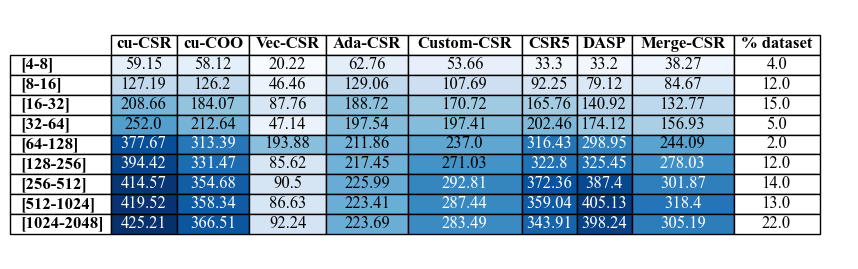

NVIDIA-H100 - anr_categ


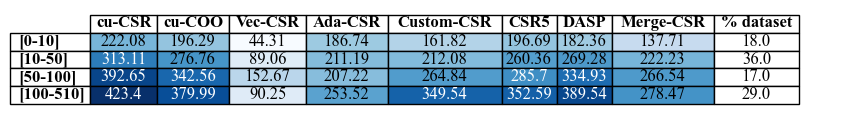

NVIDIA-H100 - skew_categ


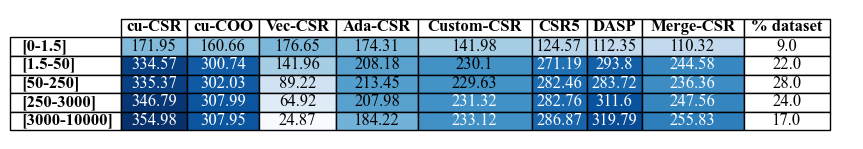

NVIDIA-H100 - regularity


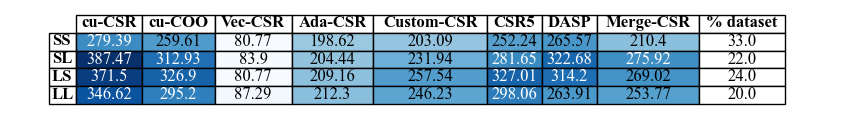

'\nNVIDIA-H100 NOTES\ncu-CSR:  overall master\nAda-CSR: as matrix size grows, gap grows too (but for large rows performs well!)\nDASP: able to sustain competitive performance when size grows\n'

In [28]:
median_format_performance_per_feature_range(df, 'NVIDIA-H100', formats_to_discard = formats_to_discard)

'''
NVIDIA-H100 NOTES
cu-CSR:  overall master
Ada-CSR: as matrix size grows, gap grows too (but for large rows performs well!)
DASP: able to sustain competitive performance when size grows
'''

AMD-MI250 - mem_range


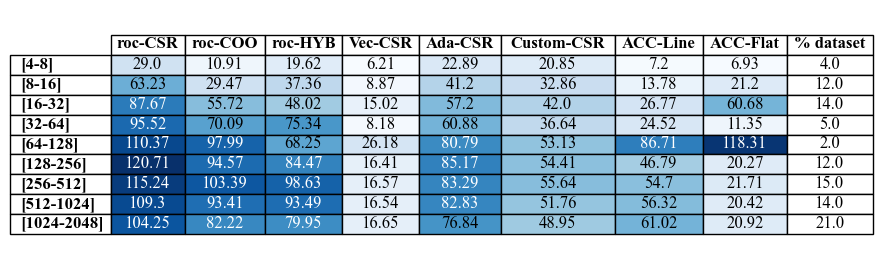

AMD-MI250 - anr_categ


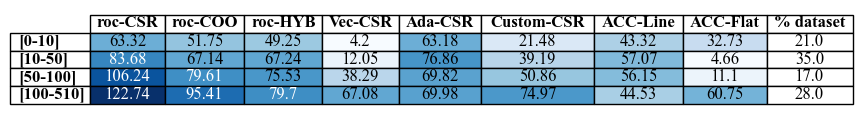

AMD-MI250 - skew_categ


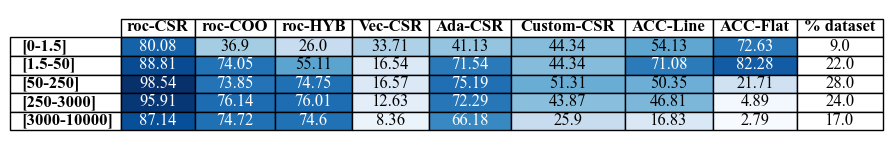

AMD-MI250 - regularity


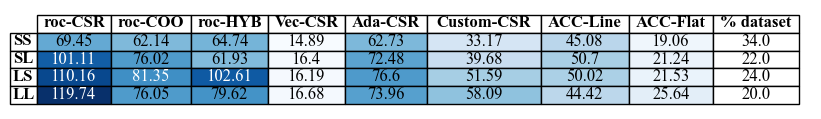

'\nAMD-MI250 NOTES\nroc-CSR:  overall master (but when imbalance large -> slight drop) (when irregularity -> large drop almost half perf)\nroc-HYB: competitive, but always loses\nAda-CSR: once again, performance drops when matrix size grows (but not that much)\nACC-Flat: complete collapse when relatively largee matrices (why????)\n'

In [29]:
median_format_performance_per_feature_range(df, 'AMD-MI250', formats_to_discard = formats_to_discard)

'''
AMD-MI250 NOTES
roc-CSR:  overall master (but when imbalance large -> slight drop) (when irregularity -> large drop almost half perf)
roc-HYB: competitive, but always loses
Ada-CSR: once again, performance drops when matrix size grows (but not that much)
ACC-Flat: complete collapse when relatively largee matrices (why????)
'''

AMD-EPYC-64 - mem_range


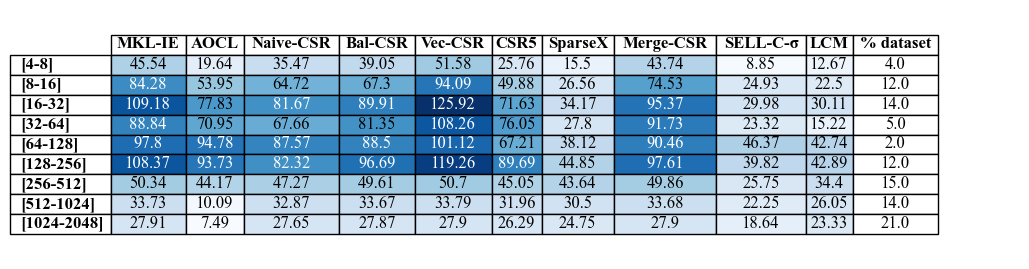

AMD-EPYC-64 - anr_categ
SMALL


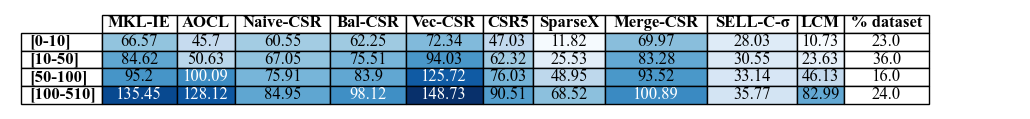

BIG


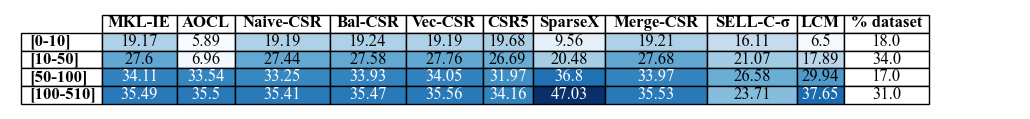

AMD-EPYC-64 - skew_categ
SMALL


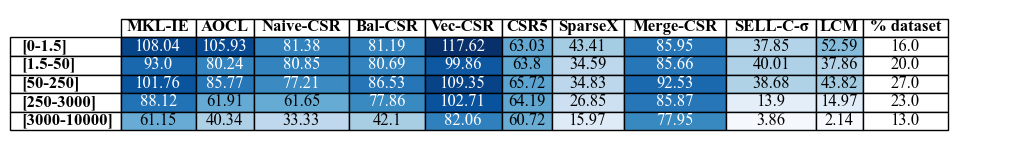

BIG


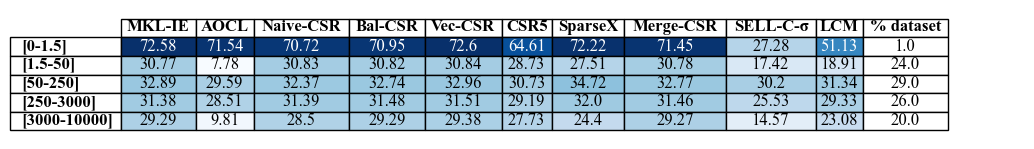

AMD-EPYC-64 - regularity
SMALL


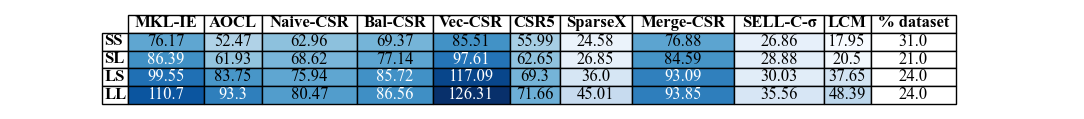

BIG


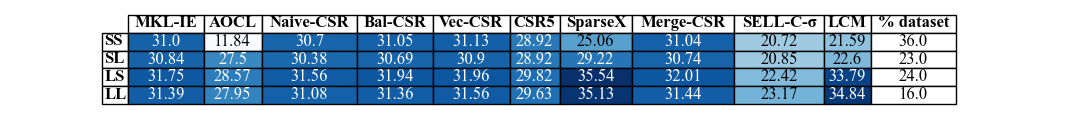

'\nAMD-EPYC-64 NOTES\nSparseX: sustain performance when matrix size large\nLCM: also good performance when matrix size large\n'

In [30]:
median_format_performance_per_feature_range(df, 'AMD-EPYC-64', is_cpu = True, llc_thresholds = llc_thresholds,
                                            formats_to_discard = formats_to_discard)

'''
AMD-EPYC-64 NOTES
SparseX: sustain performance when matrix size large
LCM: also good performance when matrix size large
'''

INTEL-SAPPHIRE-56 - mem_range


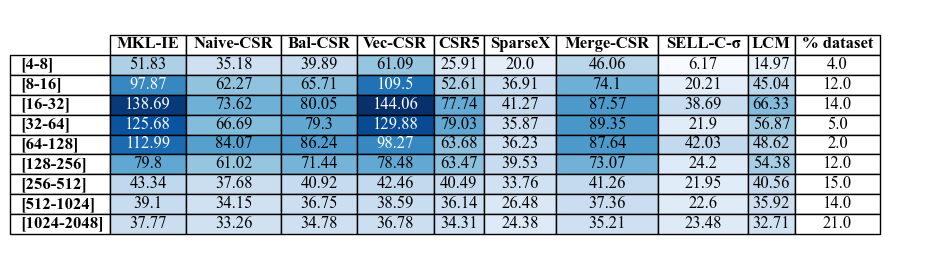

INTEL-SAPPHIRE-56 - anr_categ
SMALL


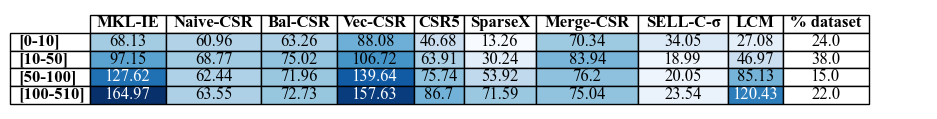

BIG


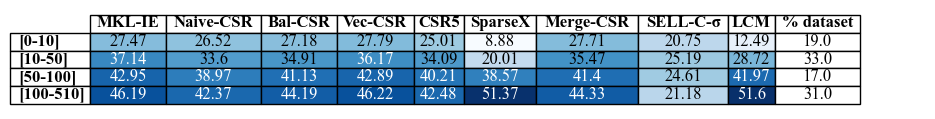

INTEL-SAPPHIRE-56 - skew_categ
SMALL


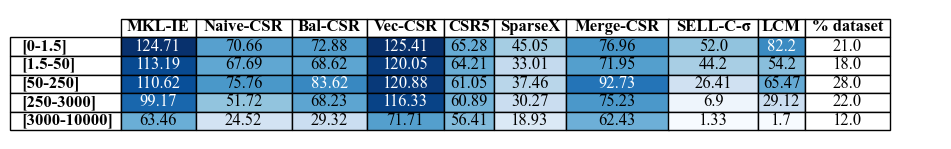

BIG


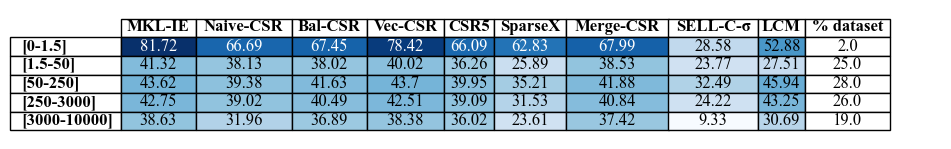

INTEL-SAPPHIRE-56 - regularity
SMALL


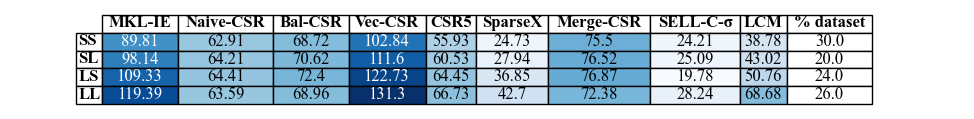

BIG


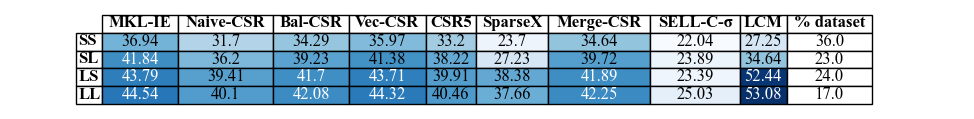

'\nINTEL-SAPPHIRE-56 NOTES\nMKL-IE and Vec-CSR work optimally for in-LLC matrices\n'

In [31]:
median_format_performance_per_feature_range(df, 'INTEL-SAPPHIRE-56', is_cpu = True, llc_thresholds = llc_thresholds,
                                            formats_to_discard = formats_to_discard)

'''
INTEL-SAPPHIRE-56 NOTES
MKL-IE and Vec-CSR work optimally for in-LLC matrices
'''

ARM-GRACE-72 - mem_range


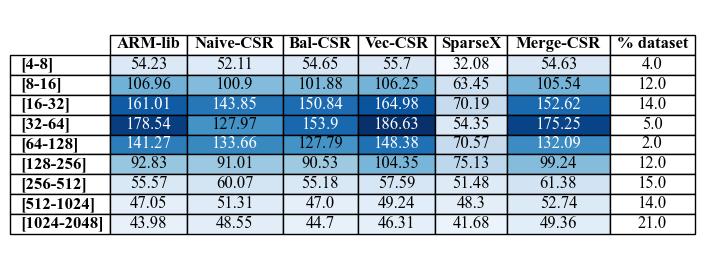

ARM-GRACE-72 - anr_categ
SMALL


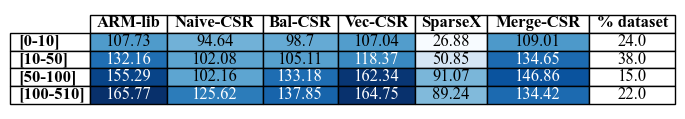

BIG


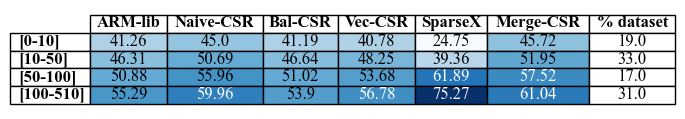

ARM-GRACE-72 - skew_categ
SMALL


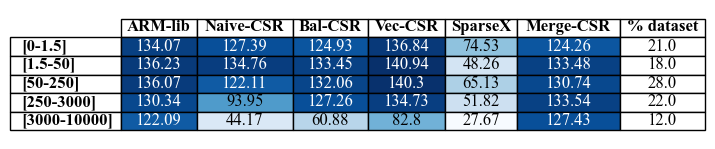

BIG


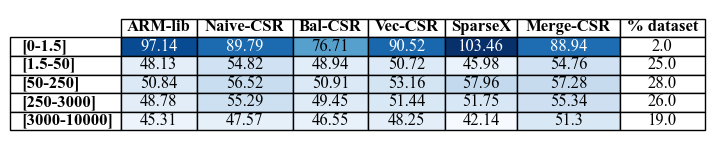

ARM-GRACE-72 - regularity
SMALL


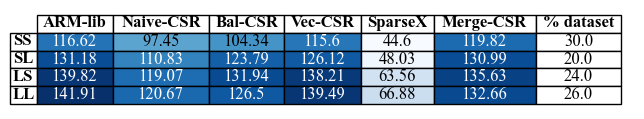

BIG


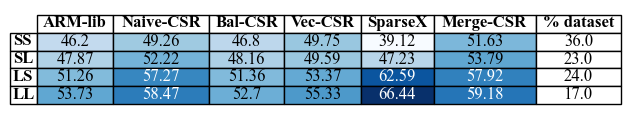

'\nARM-GRACE-72 NOTES\nARM-lib: no change when imbalance grows in small matrices\nMerge-CSR: competitive performance\n'

In [32]:
median_format_performance_per_feature_range(df, 'ARM-GRACE-72', is_cpu = True, llc_thresholds = llc_thresholds,
                                            formats_to_discard = formats_to_discard)

'''
ARM-GRACE-72 NOTES
ARM-lib: no change when imbalance grows in small matrices
Merge-CSR: competitive performance
'''

---
# ------- ------- ------- ------- EXTRA ------- ------- ------- ------- 

In [33]:
def print_distribution_col100(feature, ranges_feature, group_system_best, verbose = True, name='', count_it=False):
    total = group_system_best.shape[0]
    if(verbose):
        print(feature + ' distribution in dataset')
    ndf_row = [name]
    for val in ranges_feature:
        group_system_best_feat = group_system_best[group_system_best[feature]==val]
        cnt = group_system_best_feat.shape[0]
        if(count_it):
            cnt2 = group_system_best.shape[0]
            new_string = str(np.round(cnt/cnt2*100))# + ' GF'
        else:
            new_string = str(np.round(group_system_best_feat['gflops'].median(),2))# + ' GF'
        if(verbose):
            print(val, '\t', cnt,'/', total,'\t', new_string)
        ndf_row.append(new_string)
    return ndf_row

def dataframe_heatmap(df, filename, file_format='png', colormap='Blues'):

    """
    Display a DataFrame as a heatmap-style table in Jupyter Notebook with a title directly above the table.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        title (str): The title for the heatmap.
        colormap (str): The name of the colormap to use (default is 'Blues').
    """
    # Exclude the last column ("% dataset") from the numeric calculations
    important_columns = df.columns[:-1]
    numeric_df = df[important_columns].apply(pd.to_numeric, errors='coerce')
    
    # Normalize the cell values to a color scale
    max_val = numeric_df.max().max() if not numeric_df.empty else 1
    min_val = numeric_df.min().min() if not numeric_df.empty else 1
    norm = Normalize(vmin=min_val, vmax=max_val)
    # cmap = plt.cm.get_cmap(colormap)
    cmap = mpl.colormaps.get_cmap(colormap)
    
    
    # Create a matplotlib figure
    fig, ax = plt.subplots(figsize=(len(df.columns), len(df) * 0.3))
    ax.axis('off')  # Turn off the axes
    
    # Create a table with cell colors
    table = ax.table(
        cellText=df.values,
        rowLabels=df.index,
        colLabels=df.columns,
        cellLoc='center',
        loc='center'
    )

    # Adjust font sizes
    table.auto_set_font_size(False)
    table.set_fontsize(12)  # Set font size for all text
    for i, col in enumerate(df.columns):
        table.auto_set_column_width([i])  # Adjust column width automatically

    # Apply colors to each cell
    for (i, j), cell in table.get_celld().items():
        if (i == 0) or (j == -1):  # Skip header and index
            cell.set_facecolor("white")
            cell.set_text_props(weight='bold', color='black')
        else:
            # Use the numeric value for coloring, if available
            try:
                if df.columns[j] in important_columns:  # Skip the last column
                    value = numeric_df.iloc[i - 1, j]
                    if not pd.isna(value):
                        intensity = cmap(norm(value))  # Get color from colormap
                        cell.set_facecolor(intensity)
                        # Adjust text color based on brightness of the background
                        brightness = np.dot(to_rgba(intensity)[:3], [0.299, 0.587, 0.114])  # Perceived brightness
                        cell.set_text_props(color='white' if brightness < 0.5 else 'black')
                    else:
                        cell.set_facecolor("white")  # Default for non-numeric
                        cell.set_text_props(color='black')
                else:
                    cell.set_facecolor("white")  # Non-important column
                    cell.set_text_props(color='black')
            except Exception:
                cell.set_facecolor("white")
                cell.set_text_props(color='black')
    
    # Add a title directly above the table
    # ax.text(0.5, 1.05, title, fontsize=12, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
    
    # Adjust layout and show the figure
    plt.tight_layout()
    plt.show()

def _analysis(df_sys, formats, feat, ranges_feat):
    new_df_list = []
    for f in formats:
        df_sys_f = df_sys[df_sys['format_name'] == f]
        # print(system, '\t', f, '\t', df_sys_f.shape[0])

        # df_sys_f = df_sys_f.round({'avg_nz_row':0, 'skew_coeff':-2})
        # print('avg_nz_row', '\t', sorted(set(df_sys_f['avg_nz_row'])))
        # print('skew_coeff', '\t', sorted(set(df_sys_f['skew_coeff'])))
        # print('regularity', '\t', sorted(set(df_sys_f['regularity'])))

        # feat, ranges_feat = features[cnt], rangess[cnt]
        ndf_row = print_distribution_col100(feat, ranges_feat, df_sys_f, verbose=False, name = f)
        new_df_list.append(ndf_row)

    extra_ndf_row = print_distribution_col100(feat, ranges_feat, df_sys_f, verbose=False, name='% dataset', count_it=True)
    new_df_list.append(extra_ndf_row)

    new_df = pd.DataFrame(new_df_list, columns = ['Format'] + ranges_feat)
    if(new_df.shape[0]>0):
        new_df.set_index('Format', inplace=True)
        new_df = new_df.T
        # display(new_df)
        return new_df
            
def median_format_performance_per_feature_range(df, system, is_cpu = False, llc_thresholds = {}, formats_to_discard  = {}):
    features = ['mem_range', 'anr_categ', 'skew_categ', 'regularity']
    rangess = [ranges_memr, ranges_anr, ranges_skew, ranges_regularity]

    for cnt in range(len(features)):
        feat, ranges_feat = features[cnt], rangess[cnt]
        # print(f'============================================\n{system} - {feat}')
        print(f'{system} - {feat}')

        df_system_list=[]
        formats = [x.split('\t')[1] for x in ranges_impl_arch_backup if 
                   ((x.split(' )')[0].split('( ')[1] == system) and 
                    (x.split('\t')[1] in set(df[df['System']==x.split(' )')[0].split('( ')[1]]['format_name'])))]
        
        df_sys = df[df['System']==system]
        
        # discard not wanted formats...
        df_sys = remove_formats(df_sys, formats_to_discard[system])
        formats = [fmt for fmt in formats if fmt not in formats_to_discard[system]]
        
        # Create the boxplot
        plt.figure(figsize=(8, 6))
        cat_it = CategoricalDtype(ranges_feat, ordered=True)
        df_sys[feat] = df_sys[feat].astype(cat_it)
        df_sys = df_sys.sort_values(feat)

        sns.boxplot(data=df_sys, x=feat, y='gflops', hue='format_name', hue_order=formats, fliersize=0.2)
        
        # Adjust plot aesthetics
        plt.xlabel(f"{features[cnt]}")
        plt.ylabel('Performance')
        plt.title('Performance Comparison by Category')
        plt.legend(title='Storage Format', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.savefig(f"./Plots/boxplot_{features[cnt]}_{system}.pdf", format="pdf", bbox_inches="tight")
        plt.close()
        
        # if(feat != 'mem_range') and (is_cpu):
        #     print('SMALL')
        #     df_sys_l = df_sys[df_sys['mem_footprint'] < llc_thresholds[system]].reset_index()
        #     new_df = _analysis(df_sys_l, formats, feat, ranges_feat)
        #     # dataframe_heatmap(new_df, filename=f'heatmap_{system}_{features[cnt]}_small', file_format='pdf')
        #     print('BIG')
        #     df_sys_h = df_sys[df_sys['mem_footprint'] > llc_thresholds[system]].reset_index()
        #     new_df = _analysis(df_sys_h, formats, feat, ranges_feat)
        #     # dataframe_heatmap(new_df, filename=f'heatmap_{system}_{features[cnt]}_big', file_format='pdf')
            
        # else:
        #     new_df = _analysis(df_sys, formats, feat, ranges_feat)
        #     # dataframe_heatmap(new_df, filename=f'heatmap_{system}_{features[cnt]}', file_format='pdf')

        # display(new_df)

        # # Create the boxplot with different hues for each format
        # plt.figure(figsize=(8, 6))
        # # hue_hue_order = ['Naive-CSR', 'Bal-CSR', 'Vec-CSR', 'Merge-CSR']
        # sns.boxplot(data=new_df, x='skew_category', y='Performance', hue='Format', hue_order=hue_hue_order)
        # # sns.stripplot(data=df_melted, 'nnz_category', y='Performance', hue='Format', hue_order=hue_hue_order, jitter=0.25, s=2, alpha=1)
    
        # # Adjust plot aesthetics
        # plt.xlabel('skew category')
        # plt.ylabel('Performance')
        # plt.title('Performance Comparison by skew Category')
        # plt.legend(title='Format', bbox_to_anchor=(1.05, 1), loc='upper left')
    
        # # plt.tight_layout()
        # # Save as PDF
        # plt.savefig(f"./Plots/low_ilp_boxplot2_{System}.pdf", format="pdf", bbox_inches="tight")
        # plt.close()  # Close the figure to avoid displaying in Jupyter

            
formats_to_discard = {
    'NVIDIA-H100':       ['Custom-CSR', 'Vec-CSR', 'cu-COO', 'CSR5', 'Merge-CSR'],
    'AMD-MI250':         ['Custom-CSR', 'Vec-CSR', 'roc-COO', 'ACC-Line'],
    'AMD-EPYC-64':       ['Naive-CSR', 'Bal-CSR', 'AOCL', 'MKL-IE', 'CSR5'],
    'INTEL-SAPPHIRE-56': ['Naive-CSR', 'Bal-CSR', 'CSR5', 'Merge-CSR', 'SELL-C-σ'],
    # 'ARM-GRACE-72':      ['Naive-CSR', 'Bal-CSR', 'SparseX'],
    # 'ARM-GRACE-72':      ['Naive-CSR', 'SparseX', 'ARM-lib'],
    'ARM-GRACE-72':      [],
}            
# formats_to_discard = {
#     'NVIDIA-H100':       [],
#     'AMD-MI250':         [],
#     'AMD-EPYC-64':       [],
#     'INTEL-SAPPHIRE-56': [],
#     'ARM-GRACE-72':      [],
# }
df = groupreps # ALL matrices for each format
median_format_performance_per_feature_range(df, 'ARM-GRACE-72', is_cpu = True, llc_thresholds = llc_thresholds,
                                            formats_to_discard = formats_to_discard)


'''
ARM-GRACE-72 NOTES
ARM-lib: no change when imbalance grows in small matrices
Merge-CSR: competitive performance
'''


ARM-GRACE-72 - mem_range
ARM-GRACE-72 - anr_categ
ARM-GRACE-72 - skew_categ
ARM-GRACE-72 - regularity


'\nARM-GRACE-72 NOTES\nARM-lib: no change when imbalance grows in small matrices\nMerge-CSR: competitive performance\n'

---
# CDF - Distribution of performance per device

In [34]:
def plot_cdf_all_devices(df, ranges_dev):
    plt.figure(figsize=(30, 18))
    change_colors(ranges_dev, color_dictionary)

    print('cdf-all-devices')
    # for System in ranges_dev:
    #     sns.ecdfplot(data=df, x=System, label=System, marker='o')

    # for System in ranges_dev:
    #     system_df = df[['id', System]]
    #     plt.plot(system_df['id'], system_df[System], marker='o', label=System)

    for System in ranges_dev:
        sorted_gflops = df[System].sort_values()/df[System].max()*100
        xvals = np.arange(1, len(sorted_gflops) + 1) / len(sorted_gflops) * 100
        plt.plot(xvals, sorted_gflops, marker='o', label=System)

    plt.title('CDF-like Plot for System Performance', fontsize=36)
    plt.xlabel('Cumulative Distribution (% of dataset)', fontsize=32)
    plt.xticks(fontsize=32)
    plt.ylabel('Performance (% of max)', fontsize=32)
    plt.yticks(fontsize=32)
    plt.legend(fontsize=22)
    plt.grid(True)
    plt.savefig(f'./Plots/cdf_perf_all_devices.png', facecolor='white', bbox_inches='tight')
    plt.close()

def plot_cdf_one_device(df, System):
    plt.figure(figsize=(30, 18))

    print('cdf-one-device:', System)
    sorted_df = np.sort(df[System].dropna())
    xvals = np.arange(1, len(sorted_df) + 1) / len(sorted_df)
    plt.plot(xvals, sorted_df, marker='o', linestyle='-', label=System)

    plt.title(f'CDF-like Plot for System Performance: {System}', fontsize=36)
    plt.xlabel('Cumulative Distribution', fontsize=32)
    plt.xticks(fontsize=32)
    plt.ylabel('Performance (gflops)', fontsize=32)
    plt.yticks(fontsize=32)
    # plt.legend(fontsize=22)
    plt.grid(True)

    plt.savefig(f'./Plots/cdf_perf_one_device_{System}.png', facecolor='white', bbox_inches='tight')
    plt.close()

def create_cumulative_perf_plots(base_df, ranges_dev):
    df = base_df[base_df['System'].isin(ranges_dev)]
    df['gflops'] = df['gflops'].round(2)

    # specific_values = {
    #     'nr_rows' : 28508159,
    #     'nr_cols' : 28508159,
    #     'nr_nzeros' : 142854412,
    #     'avg_nnz_per_row' : 5.011001,
    #     'std_nnz_per_row' : 1.667977,
    #     'avg_bw_scaled' : 0.588275,
    #     'std_bw_scaled' : 0.308849,
    #     'avg_sc' : 0.046695,
    #     'std_sc' : 0.210983,
    #     'skew' : 100.776073,
    #     'avg_num_neighbours' : 0.723876,
    #     'cross_row_similarity' : 0.520373,
    # }
    # filtered_df = df.loc[(df[list(specific_values)] == pd.Series(specific_values)).all(axis=1)]

    # Matrix features to group by
    matrix_features = ['nr_rows', 'nr_cols', 'nr_nzeros', 'mem_footprint', 'mem_range',
                       'avg_nnz_per_row', 'std_nnz_per_row', 
                       'avg_bw_scaled', 'std_bw_scaled', 
                       'avg_sc', 'std_sc', 
                       'skew', 'avg_num_neighbours', 'cross_row_similarity',
                       'anr_categ', 'skew_categ', 'crs_categ', 'ann_categ', 'regularity',
                       ]
    # when testing with the validation (enhanced) matrices dataset
    # matrix_features = ['matrix_name', 'mem_footprint']
    
    # Pivot the data so that 'gflops' is stored under each 'System'
    # df_pivot = df.pivot_table(index=matrix_features, columns='System', values='gflops').reset_index()
    
    # Pivot the data so that both 'gflops' and 'format_name' are stored under each 'System'
    df_pivot = df.pivot_table(index=matrix_features, columns='System', values=['gflops', 'format_name'], 
                              aggfunc='first').reset_index()

    # Flatten the column MultiIndex (if necessary)
    # join tuple elements by _
    df_pivot.columns = ['/'.join(col).strip() if col[1]!='' else col[0] for col in df_pivot.columns]
    # remove gflops_ from columns containing the system names..
    df_pivot.columns = [col.strip('gflops/') if 'gflops' in col else col for col in df_pivot.columns]
    
    df_pivot.insert(0, 'id', range(1, len(df_pivot) + 1))
    # df_pivot['mem_footprint'] = df_pivot['mem_footprint'].round(2)
    # df_pivot['avg_nnz_per_row'] = df_pivot['avg_nnz_per_row'].round(2)
    # df_pivot['std_nnz_per_row'] = df_pivot['std_nnz_per_row'].round(4)
    # df_pivot['avg_bw_scaled'] = df_pivot['avg_bw_scaled'].round(4)
    # df_pivot['std_bw_scaled'] = df_pivot['std_bw_scaled'].round(4)
    # df_pivot['avg_sc'] = df_pivot['avg_sc'].round(4)
    # df_pivot['std_sc'] = df_pivot['std_sc'].round(4)
    # df_pivot['skew'] = df_pivot['skew'].round(4)
    # df_pivot['avg_num_neighbours'] = df_pivot['avg_num_neighbours'].round(4)
    # df_pivot['cross_row_similarity'] = df_pivot['cross_row_similarity'].round(4)

    plot_cdf_all_devices(df_pivot, ranges_dev)
    # for System in ranges_dev:
    #     plot_cdf_one_device(df_pivot, System)
    return df_pivot

base_df = group_system_best
ranges_dev = ['NVIDIA-H100', 'AMD-MI250', 'AMD-EPYC-64', 'INTEL-SAPPHIRE-56', 'ARM-GRACE-72']
# ranges_dev = ['AMD-EPYC-64', 'INTEL-SAPPHIRE-56', 'ARM-GRACE-72']
df_pivot = create_cumulative_perf_plots(base_df, ranges_dev)


cdf-all-devices


---
# Performance range of each device

In [35]:
def print_performance_ranges(df, System):
    sys_df = df[df['System']==System]
    # sys_df = sys_df[sys_df['format_name']!='LCM']
    sys_min_perf = sys_df['gflops'].min()
    sys_max_perf = sys_df['gflops'].max()
    # quartiles = [np.ceil(0.25*i*(sys_max_perf - np.floor(sys_min_perf))) for i in range(5)]
    # Generate the quartiles
    quartiles = np.percentile([sys_min_perf, sys_max_perf], [0, 12.5, 25, 50, 75, 100])
    quartiles = [int(q) for q in quartiles]
    
    print('Performance ranges for system:', System)
    for i in range(len(quartiles)-1):
        limits = (quartiles[i], quartiles[i+1])
        filtered_sys_df = sys_df[(sys_df['gflops'] >= limits[0]) & (sys_df['gflops'] <= limits[1])]
        print(f'{i+1}) {quartiles[i]} - {quartiles[i+1]} GF', '\t', f'{filtered_sys_df.shape[0]}/{sys_df.shape[0]}', f'\t{np.round(filtered_sys_df.shape[0]/sys_df.shape[0]*100,2)} %')
        
        if(i>=len(quartiles)-3):
            filtered_sys_df['avg_nnz_per_row'] = filtered_sys_df['avg_nnz_per_row'].round()
            filtered_sys_df['mem_footprint'] = filtered_sys_df['mem_footprint'].round(-1)
            # print('avg_nnz_per_row', sorted(set(filtered_sys_df['avg_nnz_per_row'])))
            # print('avg_nnz_per_row', Counter(filtered_sys_df['avg_nnz_per_row']))
            sorted_mem_footprint_counter = dict(sorted(Counter(filtered_sys_df['mem_footprint']).items()))
            sorted_formats_counter = dict(sorted(Counter(filtered_sys_df['format_name']).items(), key=lambda item: item[1]))
            # print('\tmem_footprint', sorted_mem_footprint_counter)
            print('\tformat_name', sorted_formats_counter)
        # if(i==0):
        #     print(set(filtered_sys_df['format_name']))
    print()
    
ranges_dev = ['NVIDIA-H100', 'AMD-MI250', 'AMD-EPYC-64', 'INTEL-SAPPHIRE-56', 'ARM-GRACE-72']
for System in ranges_dev:
    print(f'===============================================================\n')
    print_performance_ranges(group_system_best, System)
    if((System=='AMD-EPYC-64') or (System=='INTEL-SAPPHIRE-56')):
        tmp = group_system_best[group_system_best['format_name']!='LCM']
        print('<<<< And now without LCM format >>>> ')
        print_performance_ranges(tmp, System)



Performance ranges for system: NVIDIA-H100
1) 51 - 120 GF 	 1337/15249 	8.77 %
2) 120 - 189 GF 	 2030/15249 	13.31 %
3) 189 - 328 GF 	 4074/15249 	26.72 %
4) 328 - 466 GF 	 4513/15249 	29.6 %
	format_name {'Custom-CSR': 35, 'Vec-CSR': 82, 'cu-COO': 96, 'CSR5': 297, 'DASP': 638, 'cu-CSR': 3365}
5) 466 - 605 GF 	 3293/15249 	21.59 %
	format_name {'Vec-CSR': 40, 'CSR5': 192, 'DASP': 651, 'cu-CSR': 2410}


Performance ranges for system: AMD-MI250
1) 21 - 47 GF 	 1690/15249 	11.08 %
2) 47 - 72 GF 	 2645/15249 	17.35 %
3) 72 - 122 GF 	 5752/15249 	37.72 %
4) 122 - 173 GF 	 3344/15249 	21.93 %
	format_name {'ACC-Line': 26, 'Ada-CSR': 39, 'Vec-CSR': 52, 'ACC-Flat': 397, 'roc-HYB': 1086, 'roc-CSR': 1744}
5) 173 - 224 GF 	 1817/15249 	11.92 %
	format_name {'ACC-Flat': 195, 'roc-HYB': 272, 'roc-CSR': 1350}


Performance ranges for system: AMD-EPYC-64
1) 2 - 31 GF 	 3004/15249 	19.7 %
2) 31 - 61 GF 	 4550/15249 	29.84 %
3) 61 - 119 GF 	 4728/15249 	31.01 %
4) 119 - 178 GF 	 2841/15249 	18.63 %
	f

---
# Where is ARM-GRACE-72 better than the NVIDIA-H100?
For 10% of the dataset, CPU reaches 85% of GPU performance

However, apart from the memory range (2-64 MB), the other features are not indicative of a pattern

And this memory range is already known that it is 'bad' and worthless for the GPU to run SpMV....

Therefore, we should leave this path of analysis...

In [36]:
# Calculate the part of the dataset where System1 reaches 'pcg' performance of System2
def compare_systems(df_pivot, System1, System2, pcg):
    test_df = df_pivot[df_pivot[System1]/df_pivot[System2] >= pcg/100.0]
    print(f'{System1} reaches at least {pcg}% of performance of {System2} for {test_df.shape[0]} matrices.')  
    return test_df
    
def display_stats(df):
    display(df.sort_values(by='mem_footprint'))
    print('mem_range', set(df['mem_range']))
    print('avg_nnz_per_row', set(df['anr_categ']))
    print('skew', set(df['skew_categ']))
    print('avg-num-neigh', set(df['ann_categ']))
    print('cross-row-similarity', set(df['crs_categ']))

df_test = compare_systems(df_pivot, 'ARM-GRACE-72', 'NVIDIA-H100', 85)
display_stats(df_test)

ARM-GRACE-72 reaches at least 85% of performance of NVIDIA-H100 for 1574 matrices.


,id,nr_rows,nr_cols,nr_nzeros,mem_footprint,mem_range,avg_nnz_per_row,std_nnz_per_row,avg_bw_scaled,std_bw_scaled,avg_sc,std_sc,skew,avg_num_neighbours,cross_row_similarity,anr_categ,skew_categ,crs_categ,ann_categ,regularity,format_name/AMD-EPYC-64,format_name/AMD-MI250,format_name/ARM-GRACE-72,format_name/INTEL-SAPPHIRE-56,format_name/NVIDIA-H100,AMD-EPYC-64,AMD-MI250,ARM-GRACE-72,INTEL-SAPPHIRE-56,NVIDIA-H100
1520,1521,17189,17189,342074,3.980301,[2-4],19.90075,6.636155,0.527262,0.438722,0.302584,0.456316,1.261221,1.770588,0.198525,[10-50],[0-1.5],S,L,SL,Vec-CSR,roc-CSR,Naive-CSR,Vec-CSR,Ada-CSR,53.36,38.20,56.12,58.69,63.51
1503,1504,17189,17189,342074,3.980301,[2-4],19.90075,6.636155,0.223988,0.106680,0.010534,0.053742,1.261221,0.812976,0.804092,[10-50],[0-1.5],L,S,LS,Vec-CSR,roc-CSR,ARM-lib,Vec-CSR,Ada-CSR,51.97,37.81,57.24,59.90,62.84
1504,1505,17189,17189,342074,3.980301,[2-4],19.90075,6.636155,0.234289,0.259072,0.395365,0.483598,1.261221,1.801522,0.044165,[10-50],[0-1.5],S,L,SL,Vec-CSR,roc-CSR,Vec-CSR,Vec-CSR,Ada-CSR,52.46,37.77,55.29,58.52,63.93
1505,1506,17189,17189,342074,3.980301,[2-4],19.90075,6.636155,0.240059,0.119495,0.015646,0.090026,1.261221,1.190824,0.810459,[10-50],[0-1.5],L,L,LL,Vec-CSR,roc-CSR,Naive-CSR,Vec-CSR,Ada-CSR,52.42,38.01,57.26,59.70,63.50
1506,1507,17189,17189,342074,3.980301,[2-4],19.90075,6.636155,0.270125,0.064272,0.005733,0.035416,1.261221,0.053760,0.425401,[10-50],[0-1.5],S,S,SS,Vec-CSR,roc-CSR,Vec-CSR,Vec-CSR,Ada-CSR,50.98,33.74,56.26,59.38,61.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3175,3176,55553,55553,2833153,32.634785,[32-64],50.99910,235.482583,0.299721,0.009178,0.003041,0.005983,1088.293734,0.092868,0.057784,[50-100],[250-3000],S,S,SS,Vec-CSR,roc-HYB,Merge-CSR,Vec-CSR,Custom-CSR,116.49,75.09,175.16,109.18,190.87
3174,3175,55553,55553,2833153,32.634785,[32-64],50.99910,235.482583,0.299659,0.009183,0.003042,0.005983,1088.293734,0.092754,0.499090,[50-100],[250-3000],S,S,SS,Vec-CSR,roc-HYB,Merge-CSR,Vec-CSR,cu-CSR,122.89,81.22,182.21,118.96,211.92
3189,3190,55553,55553,2833153,32.634785,[32-64],50.99910,235.482583,0.599663,0.022609,0.001521,0.004237,1088.293734,0.520537,0.052787,[50-100],[250-3000],S,S,SS,Vec-CSR,roc-CSR,Vec-CSR,Vec-CSR,cu-CSR,98.89,71.44,180.02,140.62,203.63
3177,3178,55553,55553,2833153,32.634785,[32-64],50.99910,235.482583,0.299947,0.011560,0.003023,0.004232,1088.293734,0.522114,0.057661,[50-100],[250-3000],S,S,SS,Vec-CSR,roc-CSR,Vec-CSR,Vec-CSR,cu-CSR,124.16,73.48,188.48,143.92,202.28


mem_range {'[2-4]', '[8-16]', '[16-32]', '[4-8]', '[32-64]'}
avg_nnz_per_row {'[10-50]', '[100-510]', '[50-100]', '[0-10]'}
skew {'[3000-10000]', '[250-3000]', '[50-250]', '[1.5-50]', '[0-1.5]'}
avg-num-neigh {'L', 'S'}
cross-row-similarity {'L', 'S'}


# Another approach: Try to find matrices that perform at 25% of max GPU performance... And see how CPU deals with them

In [37]:
def plot_scatter_GPU_vs_CPU(df, System1, System2, pcg):
    
    test_df[f'{System1}_max%'] = np.round(100*test_df[System1]/test_df[System1].max(),1)
    test_df[f'{System2}_max%'] = np.round(100*test_df[System2]/test_df[System2].max(),1)
    filtered_test_df = test_df[test_df[f'{System1}_max%'] < pcg]
    # Matrix features to group by
    matrix_features = ['nr_rows', 'nr_cols', 'nr_nzeros', 'mem_footprint', 'mem_range',
                       'avg_nnz_per_row', 'std_nnz_per_row', 
                       'avg_bw_scaled', 'std_bw_scaled', 
                       'avg_sc', 'std_sc', 
                       'skew', 'avg_num_neighbours', 'cross_row_similarity',
                       'anr_categ', 'skew_categ', 'crs_categ', 'ann_categ', 'regularity',
                       ]
    filtered_test_df = filtered_test_df[matrix_features + [f'format_name/{System1}', System1, f'{System1}_max%', 
                                                           f'format_name/{System2}', System2, f'{System2}_max%']]
    # display(filtered_test_df)
    #############################################################################
    plt.figure(figsize=(30, 30))
    # First, plot perf % (% of max per device performance)
    sns.scatterplot(data=filtered_test_df, x=System1+'_max%', y=System2+'_max%', s=15, edgecolor='none', color='blue')

    # Adding the x = y line
    x_values = np.linspace(0, 60, 100)
    plt.plot(x_values, x_values, color='red', linestyle='--', label='x = y')

    plt.title(f'Scatter Plot of performance: {System1} vs {System2}', fontsize=36)
    plt.xlabel(f'perf (% of max) ({System1})', fontsize=32)
    plt.xticks(fontsize=32)
    plt.xlim([0,60])
    plt.ylabel(f'perf (% of max) ({System2})', fontsize=32)
    plt.yticks(fontsize=32)
    plt.ylim([0,60])
    plt.grid(True)
    plt.savefig(f'./Plots/scatter_perf_{System1}_vs_{System2}.png', facecolor='white', bbox_inches='tight')
    plt.close()
    #############################################################################
    # Second, plot pure performance (gflops)
    plt.figure(figsize=(30, 30))
    sns.scatterplot(data=filtered_test_df, x=System1, y=System2, s=15, edgecolor='none', color='blue')
                    

    # Adding the x = y line
    x_values = np.linspace(0, 160, 100)
    plt.plot(x_values, x_values, color='red', linestyle='--', label='x = y')

    plt.title(f'Scatter Plot of performance: {System1} vs {System2}', fontsize=36)
    plt.xlabel(f'perf (gflops) ({System1})', fontsize=32)
    plt.xticks(fontsize=32)
    plt.xlim([0, 160])
    plt.ylabel(f'perf (gflops) ({System2})', fontsize=32)
    plt.yticks(fontsize=32)
    plt.ylim([0, 160])
    plt.grid(True)
    plt.savefig(f'./Plots/scatter_perf_{System1}_vs_{System2}_alternative.png', facecolor='white', bbox_inches='tight')
    plt.close()
    #############################################################################

    # Above the y=x line (System2 overperforms System1 relative to their peak performance)
    over_df = filtered_test_df[filtered_test_df[f'{System2}_max%'] >= filtered_test_df[f'{System1}_max%']]
    over_df = over_df.sort_values(by='mem_footprint')
    display(over_df)

    under_df = filtered_test_df[filtered_test_df[f'{System2}_max%'] < filtered_test_df[f'{System1}_max%']]
    under_df = under_df.sort_values(by='mem_footprint')
    display(under_df)
    
    print(f'Matrices underperforming in GPU ({System1}) (<{pcg}% of max GPU performance):')
    print('total       :', filtered_test_df.shape[0], 
          '\nCPU% > GPU% :', over_df.shape[0], ', of which CPU>GPU (in pure gflops):', over_df[over_df[System2]/over_df[System1] >= 1].shape[0],
          '\nCPU% < GPU% :', under_df.shape[0], 
         )
    return filtered_test_df

test_df = df_pivot
# display(test_df)
pcg = 25 # 25% of max performnace of System1
filtered_test_df = plot_scatter_GPU_vs_CPU(test_df, 'NVIDIA-H100', 'ARM-GRACE-72', pcg)
# filtered_test_df = plot_scatter_GPU_vs_CPU(test_df, 'AMD-MI250', 'AMD-EPYC-64', pcg)
# filtered_test_df = plot_scatter_GPU_vs_CPU(test_df, 'NVIDIA-A100', 'ARM-GRACE-72', pcg)


,nr_rows,nr_cols,nr_nzeros,mem_footprint,mem_range,avg_nnz_per_row,std_nnz_per_row,avg_bw_scaled,std_bw_scaled,avg_sc,std_sc,skew,avg_num_neighbours,cross_row_similarity,anr_categ,skew_categ,crs_categ,ann_categ,regularity,format_name/NVIDIA-H100,NVIDIA-H100,NVIDIA-H100_max%,format_name/ARM-GRACE-72,ARM-GRACE-72,ARM-GRACE-72_max%
0,698,698,340181,3.895729,[2-4],487.365330,148.285395,0.698352,0.212260,0.999666,0.007239,0.432191,1.995873,0.853019,[100-510],[0-1.5],L,L,LL,Ada-CSR,69.95,11.6,Vec-CSR,56.06,21.1
32,698,698,340181,3.895729,[2-4],487.365330,148.285395,0.988366,0.076072,0.708304,0.210087,0.432191,1.590935,0.901879,[100-510],[0-1.5],L,L,LL,Ada-CSR,69.80,11.5,Vec-CSR,56.26,21.2
31,698,698,340181,3.895729,[2-4],487.365330,148.285395,0.911973,0.180556,0.774022,0.191122,0.432191,1.676954,0.879620,[100-510],[0-1.5],L,L,LL,Ada-CSR,70.33,11.6,ARM-lib,56.08,21.1
30,698,698,340181,3.895729,[2-4],487.365330,148.285395,0.878753,0.062307,0.788913,0.212612,0.432191,1.775766,0.897959,[100-510],[0-1.5],L,L,LL,Ada-CSR,69.20,11.4,Naive-CSR,55.38,20.9
29,698,698,340181,3.895729,[2-4],487.365330,148.285395,0.820835,0.237266,0.868714,0.151928,0.432191,1.838004,0.855681,[100-510],[0-1.5],L,L,LL,Ada-CSR,69.61,11.5,ARM-lib,54.89,20.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7473,311295,311295,1606480,19.572205,[16-32],5.160635,89.624483,0.048758,0.018312,0.004479,0.062906,9689.667142,0.450266,0.050239,[0-10],[3000-10000],S,S,SS,cu-CSR,143.08,23.6,Merge-CSR,127.79,48.2
4254,81651,81651,1714651,19.934101,[16-32],20.999755,285.674650,0.299282,0.021482,0.000835,0.003497,3887.188209,0.142167,0.051194,[10-50],[3000-10000],S,S,SS,cu-CSR,145.93,24.1,Merge-CSR,140.66,53.0
4268,81651,81651,1714651,19.934101,[16-32],20.999755,285.674650,0.598358,0.042699,0.000424,0.003498,3887.188209,0.141555,0.050436,[10-50],[3000-10000],S,S,SS,cu-CSR,146.74,24.2,Merge-CSR,128.94,48.6
5708,160668,160668,1706690,20.144421,[16-32],10.622464,249.503925,0.597198,0.083788,0.000112,0.002118,9414.894720,0.142061,0.050040,[10-50],[3000-10000],S,S,SS,cu-CSR,148.98,24.6,ARM-lib,90.22,34.0


,nr_rows,nr_cols,nr_nzeros,mem_footprint,mem_range,avg_nnz_per_row,std_nnz_per_row,avg_bw_scaled,std_bw_scaled,avg_sc,std_sc,skew,avg_num_neighbours,cross_row_similarity,anr_categ,skew_categ,crs_categ,ann_categ,regularity,format_name/NVIDIA-H100,NVIDIA-H100,NVIDIA-H100_max%,format_name/ARM-GRACE-72,ARM-GRACE-72,ARM-GRACE-72_max%
13310,6815743,6815743,34081980,416.037308,[256-512],5.000479,1.690219,0.552248,0.256926,0.038216,0.191710,1.799732,0.398178,0.043241,[0-10],[1.5-50],S,S,SS,cu-CSR,140.30,23.2,Merge-CSR,41.04,15.5
13312,6815743,6815743,34081980,416.037308,[256-512],5.000479,1.690219,0.560712,0.207588,0.015731,0.124425,1.799732,0.039862,0.042429,[0-10],[1.5-50],S,S,SS,cu-CSR,136.30,22.5,Vec-CSR,40.94,15.4
13349,6815743,6815743,34089057,416.118298,[256-512],5.001517,2.238206,0.585036,0.219311,0.003915,0.062433,1000.696011,0.400118,0.049859,[0-10],[250-3000],S,S,SS,cu-CSR,141.36,23.4,Merge-CSR,41.69,15.7
13358,6815743,6815743,34089057,416.118298,[256-512],5.001517,2.238206,0.593932,0.163594,0.000002,0.000663,1000.696011,0.040075,0.050019,[0-10],[250-3000],S,S,SS,cu-CSR,137.41,22.7,Vec-CSR,40.09,15.1
13394,6815743,6815743,34128720,416.572205,[256-512],5.007337,19.153882,0.585033,0.219309,0.003916,0.062434,9986.345187,0.400254,0.049863,[0-10],[3000-10000],S,S,SS,cu-CSR,141.30,23.3,Merge-CSR,41.50,15.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15229,28508159,28508159,142854412,1743.589005,[1024-2048],5.011001,1.667977,0.292600,0.109671,0.003919,0.062473,100.776073,0.400157,0.049985,[0-10],[50-250],S,S,SS,Ada-CSR,102.46,16.9,Merge-CSR,20.68,7.8
15247,28508159,28508159,142854412,1743.589005,[1024-2048],5.011001,1.667977,0.593916,0.163622,0.000001,0.000701,100.776073,0.040010,0.499965,[0-10],[50-250],S,S,SS,cu-CSR,127.70,21.1,Vec-CSR,15.54,5.9
14697,14713889,14713889,147462951,1743.708584,[1024-2048],10.022024,3.338283,0.590699,0.110428,0.000006,0.002134,100.775847,0.450171,0.049948,[10-50],[50-250],S,S,SS,cu-CSR,117.57,19.4,Merge-CSR,32.30,12.2
14700,14713889,14713889,147462951,1743.708584,[1024-2048],10.022024,3.338283,0.596922,0.083530,0.000001,0.000000,100.775847,0.045014,0.049903,[10-50],[50-250],S,S,SS,cu-CSR,101.65,16.8,Merge-CSR,33.88,12.8


Matrices underperforming in GPU (NVIDIA-H100) (<25% of max GPU performance):
total       : 2097 
CPU% > GPU% : 1907 , of which CPU>GPU (in pure gflops): 42 
CPU% < GPU% : 190


In [38]:
System1 = 'NVIDIA-H100'
System2 = 'ARM-GRACE-72'
filtered_test_df1 = filtered_test_df[(filtered_test_df[f'{System2}_max%'] > filtered_test_df[f'{System1}_max%']) & (filtered_test_df[f'{System2}_max%'] < 25)]
filtered_test_df1 = filtered_test_df1.sort_values(by='mem_footprint')
display(filtered_test_df1)
filtered_test_df2 = filtered_test_df[(filtered_test_df[f'{System2}_max%'] > filtered_test_df[f'{System1}_max%']) & (filtered_test_df[f'{System2}_max%'] > 25)]
filtered_test_df2 = filtered_test_df2.sort_values(by='mem_footprint')
display(filtered_test_df2)


,nr_rows,nr_cols,nr_nzeros,mem_footprint,mem_range,avg_nnz_per_row,std_nnz_per_row,avg_bw_scaled,std_bw_scaled,avg_sc,std_sc,skew,avg_num_neighbours,cross_row_similarity,anr_categ,skew_categ,crs_categ,ann_categ,regularity,format_name/NVIDIA-H100,NVIDIA-H100,NVIDIA-H100_max%,format_name/ARM-GRACE-72,ARM-GRACE-72,ARM-GRACE-72_max%
0,698,698,340181,3.895729,[2-4],487.365330,148.285395,0.698352,0.212260,0.999666,0.007239,0.432191,1.995873,0.853019,[100-510],[0-1.5],L,L,LL,Ada-CSR,69.95,11.6,Vec-CSR,56.06,21.1
32,698,698,340181,3.895729,[2-4],487.365330,148.285395,0.988366,0.076072,0.708304,0.210087,0.432191,1.590935,0.901879,[100-510],[0-1.5],L,L,LL,Ada-CSR,69.80,11.5,Vec-CSR,56.26,21.2
31,698,698,340181,3.895729,[2-4],487.365330,148.285395,0.911973,0.180556,0.774022,0.191122,0.432191,1.676954,0.879620,[100-510],[0-1.5],L,L,LL,Ada-CSR,70.33,11.6,ARM-lib,56.08,21.1
30,698,698,340181,3.895729,[2-4],487.365330,148.285395,0.878753,0.062307,0.788913,0.212612,0.432191,1.775766,0.897959,[100-510],[0-1.5],L,L,LL,Ada-CSR,69.20,11.4,Naive-CSR,55.38,20.9
29,698,698,340181,3.895729,[2-4],487.365330,148.285395,0.820835,0.237266,0.868714,0.151928,0.432191,1.838004,0.855681,[100-510],[0-1.5],L,L,LL,Ada-CSR,69.61,11.5,ARM-lib,54.89,20.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3708,65535,65535,377680,4.572205,[4-8],5.763027,195.332031,0.057710,0.152068,0.815070,0.387946,8676.730751,1.576763,0.049339,[0-10],[3000-10000],S,L,SL,cu-COO,62.13,10.3,Merge-CSR,55.11,20.8
3709,65535,65535,377680,4.572205,[4-8],5.763027,195.332031,0.273241,0.249435,0.254505,0.434831,8676.730751,1.220509,0.939953,[0-10],[3000-10000],L,L,LL,cu-COO,64.12,10.6,ARM-lib,54.18,20.4
3710,65535,65535,377680,4.572205,[4-8],5.763027,195.332031,0.275218,0.077481,0.000526,0.014611,8676.730751,0.298750,0.941247,[0-10],[3000-10000],L,S,LS,cu-CSR,63.77,10.5,Merge-CSR,55.80,21.0
3701,65535,65535,377680,4.572205,[4-8],5.763027,195.332031,0.048387,0.042396,0.241516,0.424771,8676.730751,1.233997,0.050568,[0-10],[3000-10000],S,L,SL,cu-COO,59.57,9.8,Merge-CSR,55.55,20.9


,nr_rows,nr_cols,nr_nzeros,mem_footprint,mem_range,avg_nnz_per_row,std_nnz_per_row,avg_bw_scaled,std_bw_scaled,avg_sc,std_sc,skew,avg_num_neighbours,cross_row_similarity,anr_categ,skew_categ,crs_categ,ann_categ,regularity,format_name/NVIDIA-H100,NVIDIA-H100,NVIDIA-H100_max%,format_name/ARM-GRACE-72,ARM-GRACE-72,ARM-GRACE-72_max%
1216,15624,15624,776948,8.951069,[8-16],49.727855,16.596640,0.036557,0.016065,0.111284,0.077754,1.252259,0.638663,0.806144,[10-50],[0-1.5],L,S,LS,Vec-CSR,128.69,21.3,ARM-lib,106.43,40.1
1242,15624,15624,776948,8.951069,[8-16],49.727855,16.596640,0.295085,0.026139,0.011437,0.026470,1.252259,0.070517,0.069766,[10-50],[0-1.5],S,S,SS,Vec-CSR,118.42,19.6,ARM-lib,104.48,39.4
1243,15624,15624,776948,8.951069,[8-16],49.727855,16.596640,0.427899,0.261920,0.126926,0.317224,1.252259,1.861329,0.044692,[10-50],[0-1.5],S,L,SL,Vec-CSR,126.31,20.9,ARM-lib,103.57,39.0
1260,15624,15624,776948,8.951069,[8-16],49.727855,16.596640,0.757621,0.353066,0.097273,0.286826,1.252259,1.843315,0.187649,[10-50],[0-1.5],S,L,SL,Vec-CSR,128.28,21.2,Vec-CSR,105.14,39.6
1244,15624,15624,776948,8.951069,[8-16],49.727855,16.596640,0.433456,0.196433,0.010545,0.027464,1.252259,0.073338,0.797759,[10-50],[0-1.5],L,S,LS,Vec-CSR,121.63,20.1,ARM-lib,112.64,42.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7473,311295,311295,1606480,19.572205,[16-32],5.160635,89.624483,0.048758,0.018312,0.004479,0.062906,9689.667142,0.450266,0.050239,[0-10],[3000-10000],S,S,SS,cu-CSR,143.08,23.6,Merge-CSR,127.79,48.2
4268,81651,81651,1714651,19.934101,[16-32],20.999755,285.674650,0.598358,0.042699,0.000424,0.003498,3887.188209,0.141555,0.050436,[10-50],[3000-10000],S,S,SS,cu-CSR,146.74,24.2,Merge-CSR,128.94,48.6
4254,81651,81651,1714651,19.934101,[16-32],20.999755,285.674650,0.299282,0.021482,0.000835,0.003497,3887.188209,0.142167,0.051194,[10-50],[3000-10000],S,S,SS,cu-CSR,145.93,24.1,Merge-CSR,140.66,53.0
5708,160668,160668,1706690,20.144421,[16-32],10.622464,249.503925,0.597198,0.083788,0.000112,0.002118,9414.894720,0.142061,0.050040,[10-50],[3000-10000],S,S,SS,cu-CSR,148.98,24.6,ARM-lib,90.22,34.0


---
# Plot histograms of performance on each device separately.
# View range of performance for each format tested

In [39]:
def plot_histogram_performance_device(data, which, System):
    data_sys = data[data['System'] == System]
    sns.histplot(data=data_sys, x='gflops', hue='format_name', element='step')
    plt.title('Histogram of performance (per format) (%s) for %s' % (which, System))
    plt.tight_layout()
    fig_name = './Plots/histogram/histogram-%s-%s.pdf' % (System, which)
    plt.savefig(fig_name)
    plt.close()
    subprocess.run(['pdfcrop', fig_name], stdout = subprocess.DEVNULL, stderr = subprocess.DEVNULL)
    subprocess.run(['mv', fig_name.replace('.pdf', '-crop.pdf'), fig_name])


def plot_histogram_performance_device_more_specific(data, which, System, feature, feature_values):
    data_sys = data[data['System'] == System]
    data_sys = data_sys[data_sys[feature].isin(feature_values) ]
    sns.histplot(data=data_sys, x='gflops', hue='format_name', element='step')
    plt.title('Histogram of performance (per format) (%s) for %s for %s = %s' % (which, System, feature, feature_values))
    plt.tight_layout()
    fig_name = './Plots/histogram/histogram-specific-%s-%s.pdf' % (System, which)
    plt.savefig(fig_name)
    plt.close()
    subprocess.run(['pdfcrop', fig_name], stdout = subprocess.DEVNULL, stderr = subprocess.DEVNULL)
    subprocess.run(['mv', fig_name.replace('.pdf', '-crop.pdf'), fig_name])


In [40]:
plt.rc('figure', figsize=(2*width,2*height))
    
ranges_dev = ['NVIDIA-H100', 'AMD-MI250', 'AMD-EPYC-64', 'INTEL-SAPPHIRE-56', 'ARM-GRACE-72']
for System in ranges_dev:
    plot_histogram_performance_device(group_system_best, 'bestof', System)
    plot_histogram_performance_device(groupreps, 'all', System)

feature = 'mem_range'
feature_values = ['[256-512]', '[512-1024]', '[1024-2048]']
for System in ranges_dev:
    plot_histogram_performance_device_more_specific(group_system_best, 'bestof', System, feature, feature_values)
    plot_histogram_performance_device_more_specific(groupreps, 'all', System, feature, feature_values)


In [41]:
def plot_per_feature_below(data, thresholds, feature, bins, System, verbose=False):
    # sns.histplot(data=data, x=feature, hue='implementation', bins=bins)
    sns.histplot(data=data, x=feature, bins=bins)

    if(verbose):
        # Access the patches (bars) in the histogram
        patches = plt.gca().patches
        # Add xtick values and bar heights as labels
        for patch in patches:
            height = patch.get_height()
            if(height>0):
                x = patch.get_x() + patch.get_width() / 2
                plt.text(x, height+1, f'{x:.2f} ({height})', ha='center', va='bottom', rotation=45)

    plt.title('Variation of %s for %s GFLOPs performance on %s' % (feature, thresholds, System))
    plt.tight_layout()
    fig_name = './Plots/histogram/histogram-%s-%s-%s.pdf' % (System, thresholds, feature)
    plt.savefig(fig_name)
    plt.close()
    subprocess.run(['pdfcrop', fig_name], stdout = subprocess.DEVNULL, stderr = subprocess.DEVNULL)
    subprocess.run(['mv', fig_name.replace('.pdf', '-crop.pdf'), fig_name])


def filter_data_performance(data, System, features, features_values, perf_thresholds):
    print('Filter applied to data on device %s: ' % (System))
    filter_data = data
    filter_data = filter_data[filter_data['System'] == System]
    for i in range(len(features)):
        print(features[i], features_values[i])
        filter_data = filter_data[filter_data[feature].isin(feature_values)]
    print()
    print('Performance range of', System, 'for these matrices:', round(filter_data['gflops'].min(),2), '-', round(filter_data['gflops'].max(),2))
    features = ['avg_nnz_per_row', 'skew', 'avg_num_neighbours', 'cross_row_similarity']
    bins = [20, 100, 20, 20]
    rounding = [0, -1, 1, 1]

    filter_data_thres = filter_data[(filter_data['gflops'] >= perf_thresholds[0]) & (filter_data['gflops'] <= perf_thresholds[1])]
    print(filter_data_thres.shape[0],'/', filter_data.shape[0], 'matrices achieve performance of', perf_thresholds, 'GFLOPs')  
    print('Implementations of performance in range ', perf_thresholds, set(filter_data_thres['format_name']))
    for i in range(len(features)):
        plot_per_feature_below(filter_data_thres, perf_thresholds, features[i], bins[i], System, verbose=True)
        print(perf_thresholds, '->', features[i], sorted(set([round(x,rounding[i]) for x in list(filter_data_thres[features[i]])])))
    print()


In [42]:
# features = ['mem_range']
# features_values = [['[1024-2048]']]
# filter_data_performance(group_system_best, 'NVIDIA-A100', features, features_values, [100,150])

# features = ['mem_range']
# # features_values = [['[256-512]','[512-1024]','[1024-2048]']]
# features_values = [['[1024-2048]']]
# filter_data_performance(group_system_best, 'Tesla-A100', features, features_values, [0,50])

# features = ['mem_range']
# # features_values = [['[256-512]','[512-1024]','[1024-2048]']]
# features_values = [['[1024-2048]']]
# filter_data_performance(group_system_best, 'Tesla-A100', features, features_values, [0,75])



---